# Analyse the Classification performance under Frequency Manipulations. 


In [1]:
WORKDIR = "/home/wustl/Dummy/Wustl/Deepfake/MasterThesis"  # specify WORKDIR here

### Imports

In [2]:

import matplotlib.pyplot as plt
import numpy as np 
import json
import os 
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns


from paper_utils import get_figsize, configure_matplotlib, create_subplot_mosaic
from calculate_MMD import get_files_from_directory,get_files_from_sub_directory


Generators = ["ProGAN", "StyleGAN", "ProjectedGAN", "Diff-StyleGAN2", "Diff-ProjectedGAN", "DDPM", "IDDPM", "ADM", "PNDM", "LDM","coco", "all", "diff", "gan"]#

Gans = ["ProGAN", "StyleGAN", "ProjectedGAN", "Diff-StyleGAN2", "Diff-ProjectedGAN"]
Diffs = ["DDPM", "IDDPM", "ADM", "PNDM", "LDM"]



Base functions

In [3]:
configure_matplotlib(
    rc={
        "xtick.labelbottom": False,
        "xtick.bottom": True,
        "xtick.labeltop": True,
        "ytick.left": True,
        "ytick.right": False,
        "figure.constrained_layout.use": False,
        "savefig.pad_inches": 0.01,
    }
)


In [4]:
experiments = {}
path_names = []
base_input_folder = "/home/wustl/Dummy/Wustl/Deepfake/MasterThesis/results/classification/butt_low_middle_freq_ce"
all_files = get_files_from_directory(base_input_folder)


for experiment_name, files in all_files.items():
    for file in files:
        parts = file.split("/")[-1].split("_")
        generator_type = parts[-1].split(".")[0]
        model_name = parts[0]
        
        try:
            with open(file, "r") as input_file:  # Assuming JSON file
                results = json.load(input_file)
        except Exception as e:
            print(f"Error reading {file}: {e}")
            continue

        experiments.setdefault(
            model_name, {}).setdefault(
                experiment_name, {}).setdefault(
                    generator_type, {key: 
                                     {metric: metric_value for metrics in values 
                                      for metric, metric_value in metrics.items()} 
                                     for key,values in results.items()
                                     })      

data = []
for encoder_name, experiment_dict in experiments.items():
    for experiment_name, generator_dict in experiment_dict.items():
        for generator_type, metrics_dict in generator_dict.items():
            for number, metrics in metrics_dict.items():
                # Create a dictionary for each combination
                flattened_dict = {
                    'Encoder': encoder_name,
                    'Experiment': experiment_name,
                    'Generator': generator_type,
                    'Number': number
                }
                # Add all metrics to this dictionary
                flattened_dict.update(metrics)
                data.append(flattened_dict)

# Converting to a DataFrame
df = pd.DataFrame(data)
df['tendency_to_overclassify_positive'] = 1 - df['test_precision']
    
df['tendency_to_overclassify_negative'] = 1 - df['test_recall']
df.to_csv("classification_results.csv")


### Compare the two generators.

First we want to understand how the two generators trained on the specific data behave when no filters are applied. Here we want to see if under normal condiations, which model handles the case of new type of generators better, see if there are any tendencies to overclassify either fake or real. 

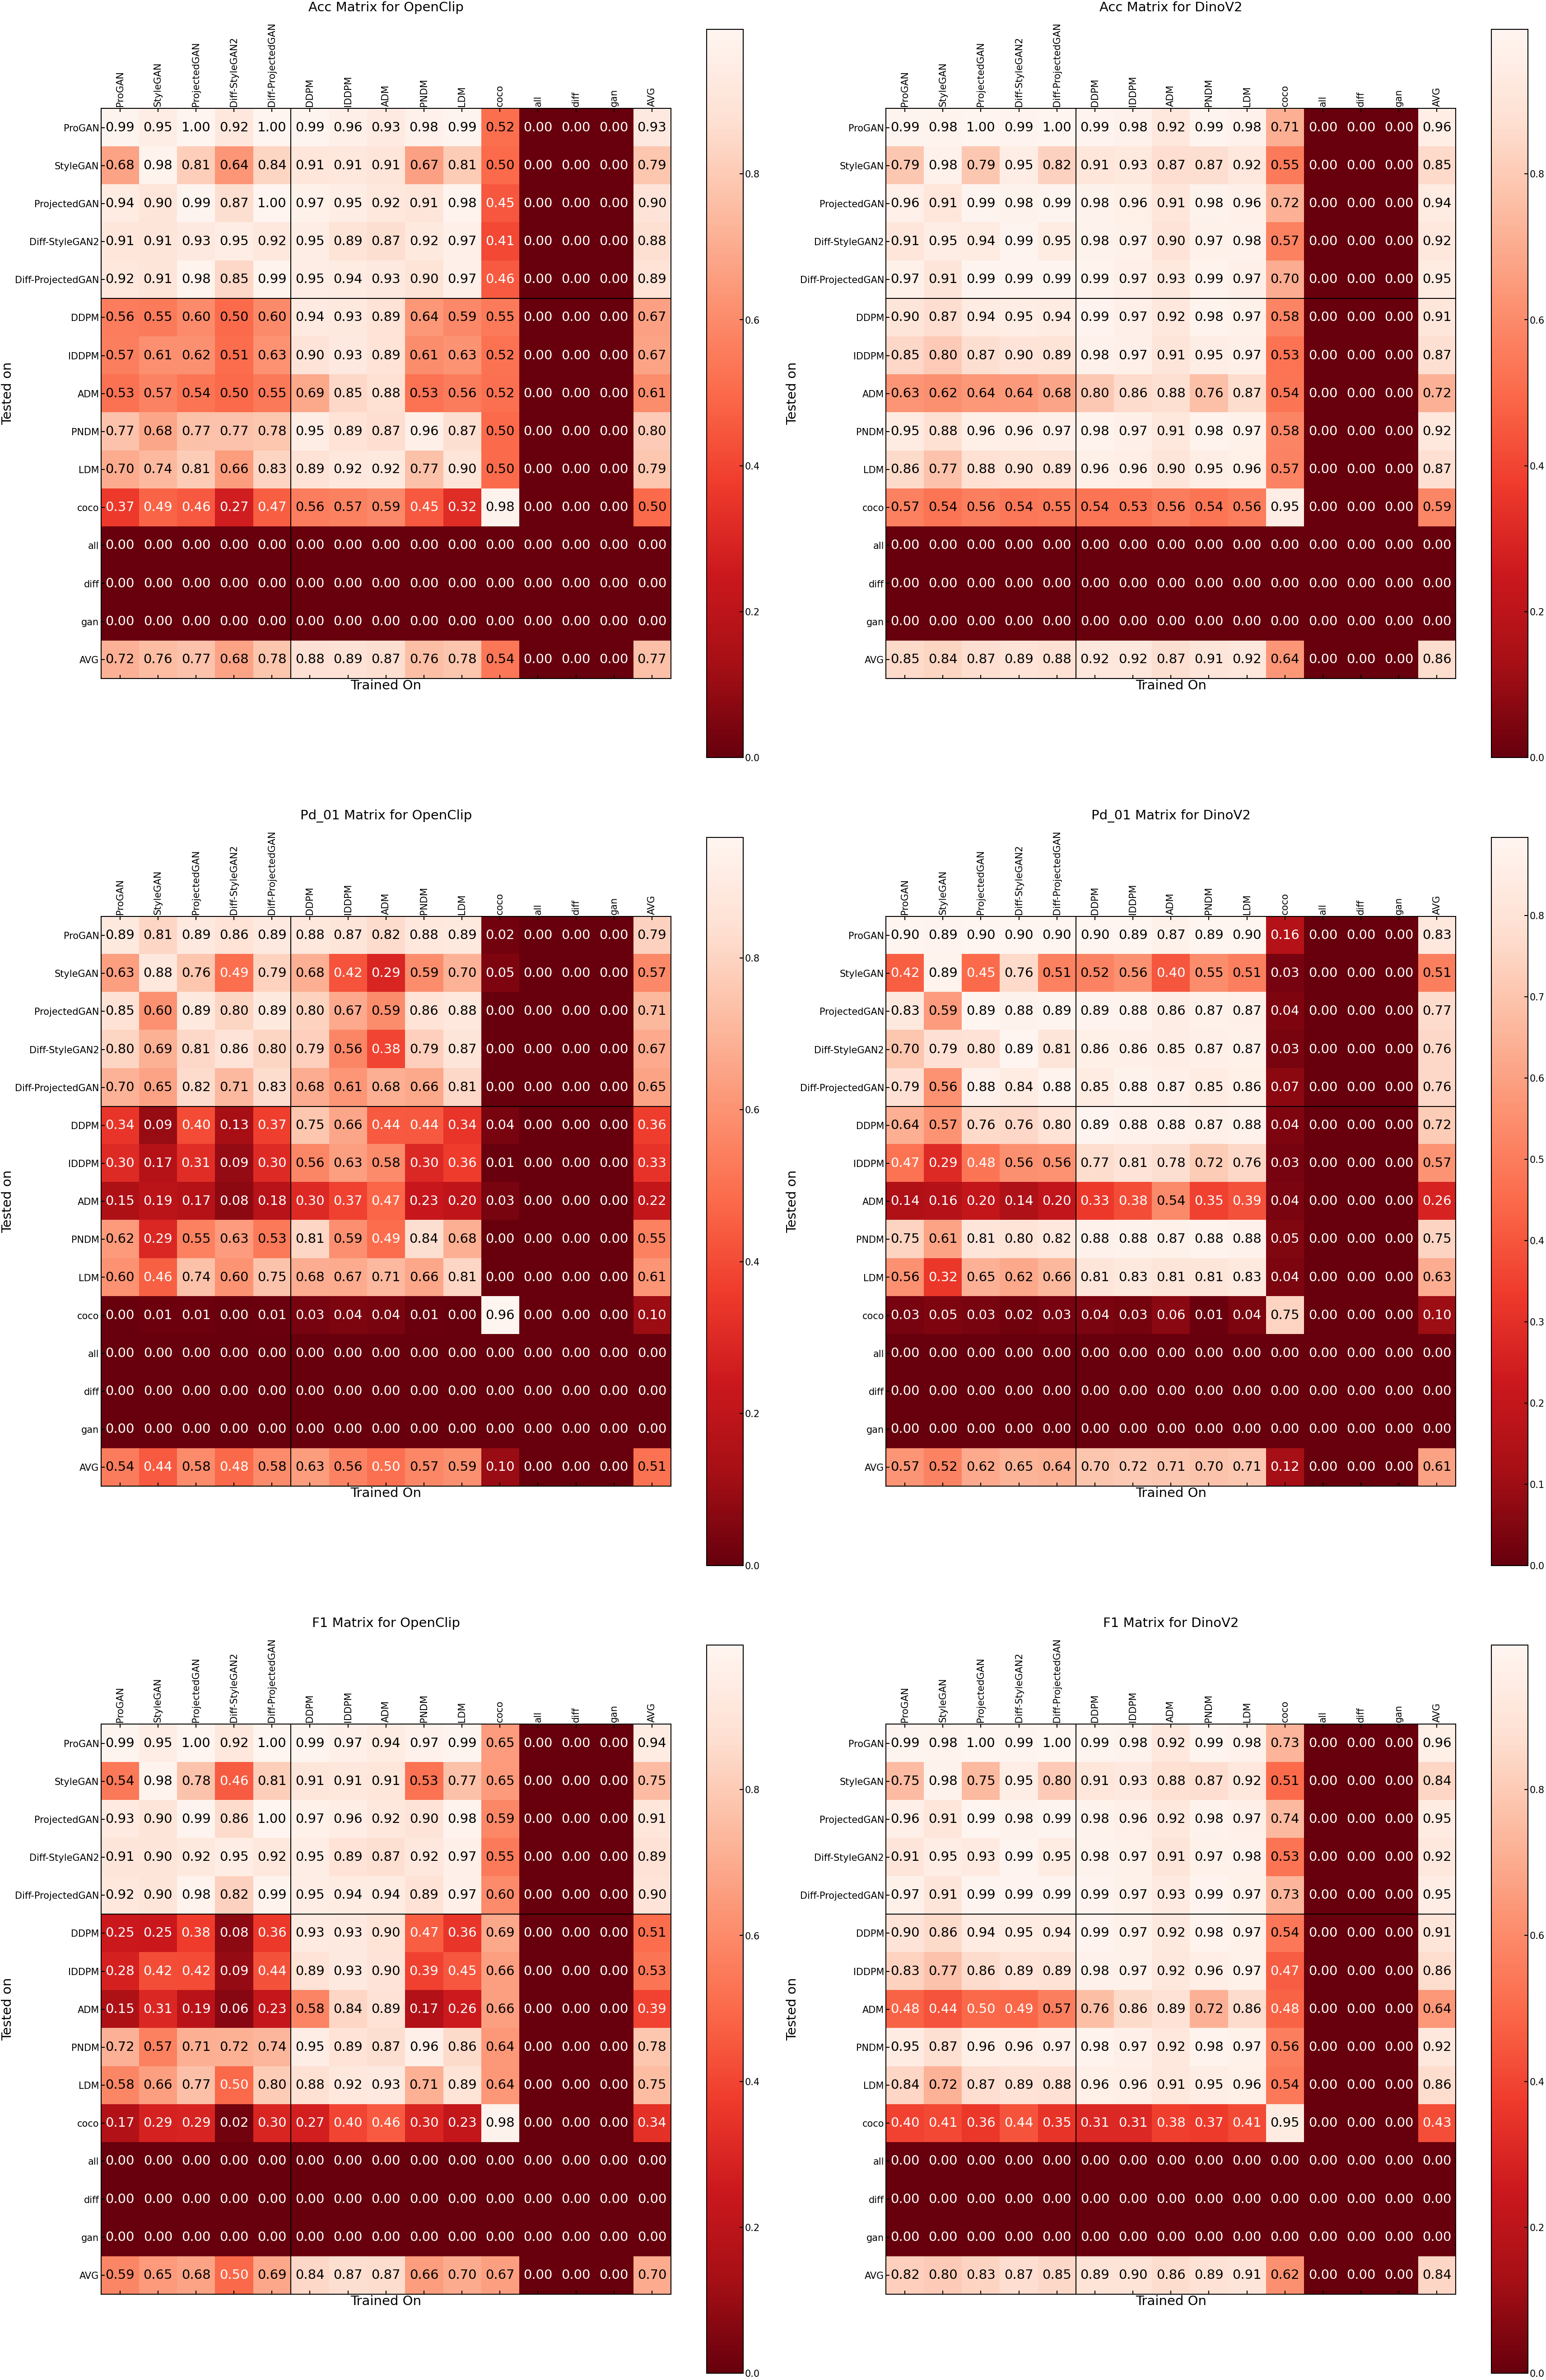

In [5]:


import numpy as np
import matplotlib.pyplot as plt

# Filter DataFrame for rows where 'Number' is "no"
df_filtered = df[(df['Number'] == "no")]#&(df['Experiment'] != 'coco') & (df['Generator'] != 'coco')



# Assuming we have two models: Model A and Model B
model_a = "OpenClip"  # Replace with the actual key for Model A
model_b = "DinoV2"  # Replace with the actual key for Model B

# Generators = ["ProGAN", "StyleGAN", "ProjectedGAN", "Diff-StyleGAN2", "Diff-ProjectedGAN", "DDPM", "IDDPM", "ADM", "PNDM", "LDM", "coco"]
metrics = ['test_acc', 'test_pd_01', 'test_f1']
gan_diff_separation_idx = Generators.index("DDPM")
# Create a figure with subplots for each metric
fig, axes = plt.subplots(len(metrics), 2, figsize=(12, 6 * len(metrics)))  # Adjust the figure size as needed
separation_idx = [Generators.index("DDPM")]#, Generators.index("coco")
# Iterate over each metric
for i, metric in enumerate(metrics):
    # Create pivot tables for each model and metric
    # Create pivot tables with swapped rows and columns
    # Create pivot tables for each model and metric
    pivot_a = df_filtered[df_filtered['Encoder'] == model_a].pivot(index='Experiment', columns='Generator', values=metric)
    pivot_b = df_filtered[df_filtered['Encoder'] == model_b].pivot(index='Experiment', columns='Generator', values=metric)
    
    # Reindex pivot tables to ensure order of Generators
    # Calculate row averages for pivot_a and pivot_b and add as a new column 'AVG'
    pivot_a['AVG'] = pivot_a.mean(axis=1)
    pivot_b['AVG'] = pivot_b.mean(axis=1)
    
    # Calculate column averages for pivot_a and pivot_b and add as a new row 'AVG'
    pivot_a.loc['AVG'] = pivot_a.mean(axis=0)
    pivot_b.loc['AVG'] = pivot_b.mean(axis=0)

    # Update Generators list to include 'AVG'
    Generators_with_avg = Generators + ['AVG']

    # Reindex pivot tables to include the 'AVG' row and column
    pivot_a = pivot_a.reindex(index=Generators_with_avg, columns=Generators_with_avg)
    pivot_b = pivot_b.reindex(index=Generators_with_avg, columns=Generators_with_avg)

    # Replace NaN values with zeros if necessary
    pivot_a = pivot_a.fillna(0)
    pivot_b = pivot_b.fillna(0)

    # Convert pivot tables to numpy arrays for plotting
    matrix_a = np.transpose(pivot_a.to_numpy())
    matrix_b = np.transpose(pivot_b.to_numpy())
    
    # Update the plots, axes titles and labels
    # First subplot for Model A
    cax1 = axes[i, 0].matshow(matrix_a, cmap=plt.cm.Reds_r)
    fig.colorbar(cax1, ax=axes[i, 0])
    axes[i, 0].set_xticks(np.arange(len(Generators_with_avg)))
    axes[i, 0].set_yticks(np.arange(len(Generators_with_avg)))
    axes[i, 0].set_xticklabels(Generators_with_avg, rotation=90)
    axes[i, 0].set_yticklabels(Generators_with_avg)
    axes[i, 0].set_xlabel('Trained On')
    axes[i, 0].set_ylabel('Tested on')
    axes[i, 0].set_title(f'{metric.replace("test_", "").capitalize()} Matrix for {model_a}')

    # Second subplot for Model B
    cax2 = axes[i, 1].matshow(matrix_b, cmap=plt.cm.Reds_r)
    fig.colorbar(cax2, ax=axes[i, 1])
    axes[i, 1].set_xticks(np.arange(len(Generators_with_avg)))
    axes[i, 1].set_yticks(np.arange(len(Generators_with_avg)))
    axes[i, 1].set_xticklabels(Generators_with_avg, rotation=90)
    axes[i, 1].set_yticklabels(Generators_with_avg)
    axes[i, 1].set_xlabel('Trained On')
    axes[i, 1].set_ylabel('Tested on')
    axes[i, 1].set_title(f'{metric.replace("test_", "").capitalize()} Matrix for {model_b}')
    for sep in separation_idx:
        axes[i, 0].axhline(y=sep-0.5, color='black', linewidth=0.5)  # Horizontal line
        axes[i, 0].axvline(x=sep-0.5, color='black', linewidth=0.5)  # Vertical line

        axes[i, 1].axhline(y=sep-0.5, color='black', linewidth=0.5)  # Horizontal line
        axes[i, 1].axvline(x=sep-0.5, color='black', linewidth=0.5)  # Vertical line

    # Adding value annotations for both matrices
    for ax, matrix in zip((axes[i, 0], axes[i, 1]), (matrix_a, matrix_b)):
        for (i, j), val in np.ndenumerate(matrix):
            text_color = 'white' if val < 0.5 else 'black'
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=text_color)

plt.tight_layout()
plt.show()

In [26]:

df_filtered = df[(df['Experiment'] != 'coco') & (df['Generator'] != 'coco')]

# Categorize each row based on whether it's in Gans or Diffs
df_filtered['Category'] = df_filtered['Experiment'].apply(lambda x: 'Gans' if x in Gans else ('Diffs' if x in Diffs else 'Other'))

# Now, group by Encoder, Number, and the new Category
average_acc_by_model_filter_category = df_filtered.groupby(['Encoder', 'Number', 'Category'])['test_f1'].mean()

# Find the maximum average accuracy for each model and category
max_average_acc_by_model_category = average_acc_by_model_filter_category.groupby(level=[0, 2]).idxmax()
max_average_values_by_model_category = average_acc_by_model_filter_category.groupby(level=[0, 2]).max()

# Display the results
print(f"The filters with the maximum average accuracy for each model and category are:\n{max_average_acc_by_model_category}")
print(f"The maximum average accuracy values for each model and category are:\n{max_average_values_by_model_category}")

The filters with the maximum average accuracy for each model and category are:
Encoder   Category
DinoV2    Diffs         (DinoV2, no, Diffs)
          Gans           (DinoV2, no, Gans)
OpenClip  Diffs       (OpenClip, no, Diffs)
          Gans         (OpenClip, no, Gans)
Name: test_f1, dtype: object
The maximum average accuracy values for each model and category are:
Encoder   Category
DinoV2    Diffs       0.942546
          Gans        0.876412
OpenClip  Diffs       0.833401
          Gans        0.660261
Name: test_f1, dtype: float64


/tmp/ipykernel_469820/1251355228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Category'] = df_filtered['Experiment'].apply(lambda x: 'Gans' if x in Gans else ('Diffs' if x in Diffs else 'Other'))


We can see, that clip has bigger problems handling diffusion trained models when trained on Gan generated data. Yet, clip can handle coco better when trained on gans and diffusion repectively. We can observe that clip tends classify images as real when faced with new type of generators. 

So in the following section, we should seperate between gan trained and diff trained models.

Now we want to see, how the models behave under the context of domain and generator shift?

### DIFF Generated Gan Tested

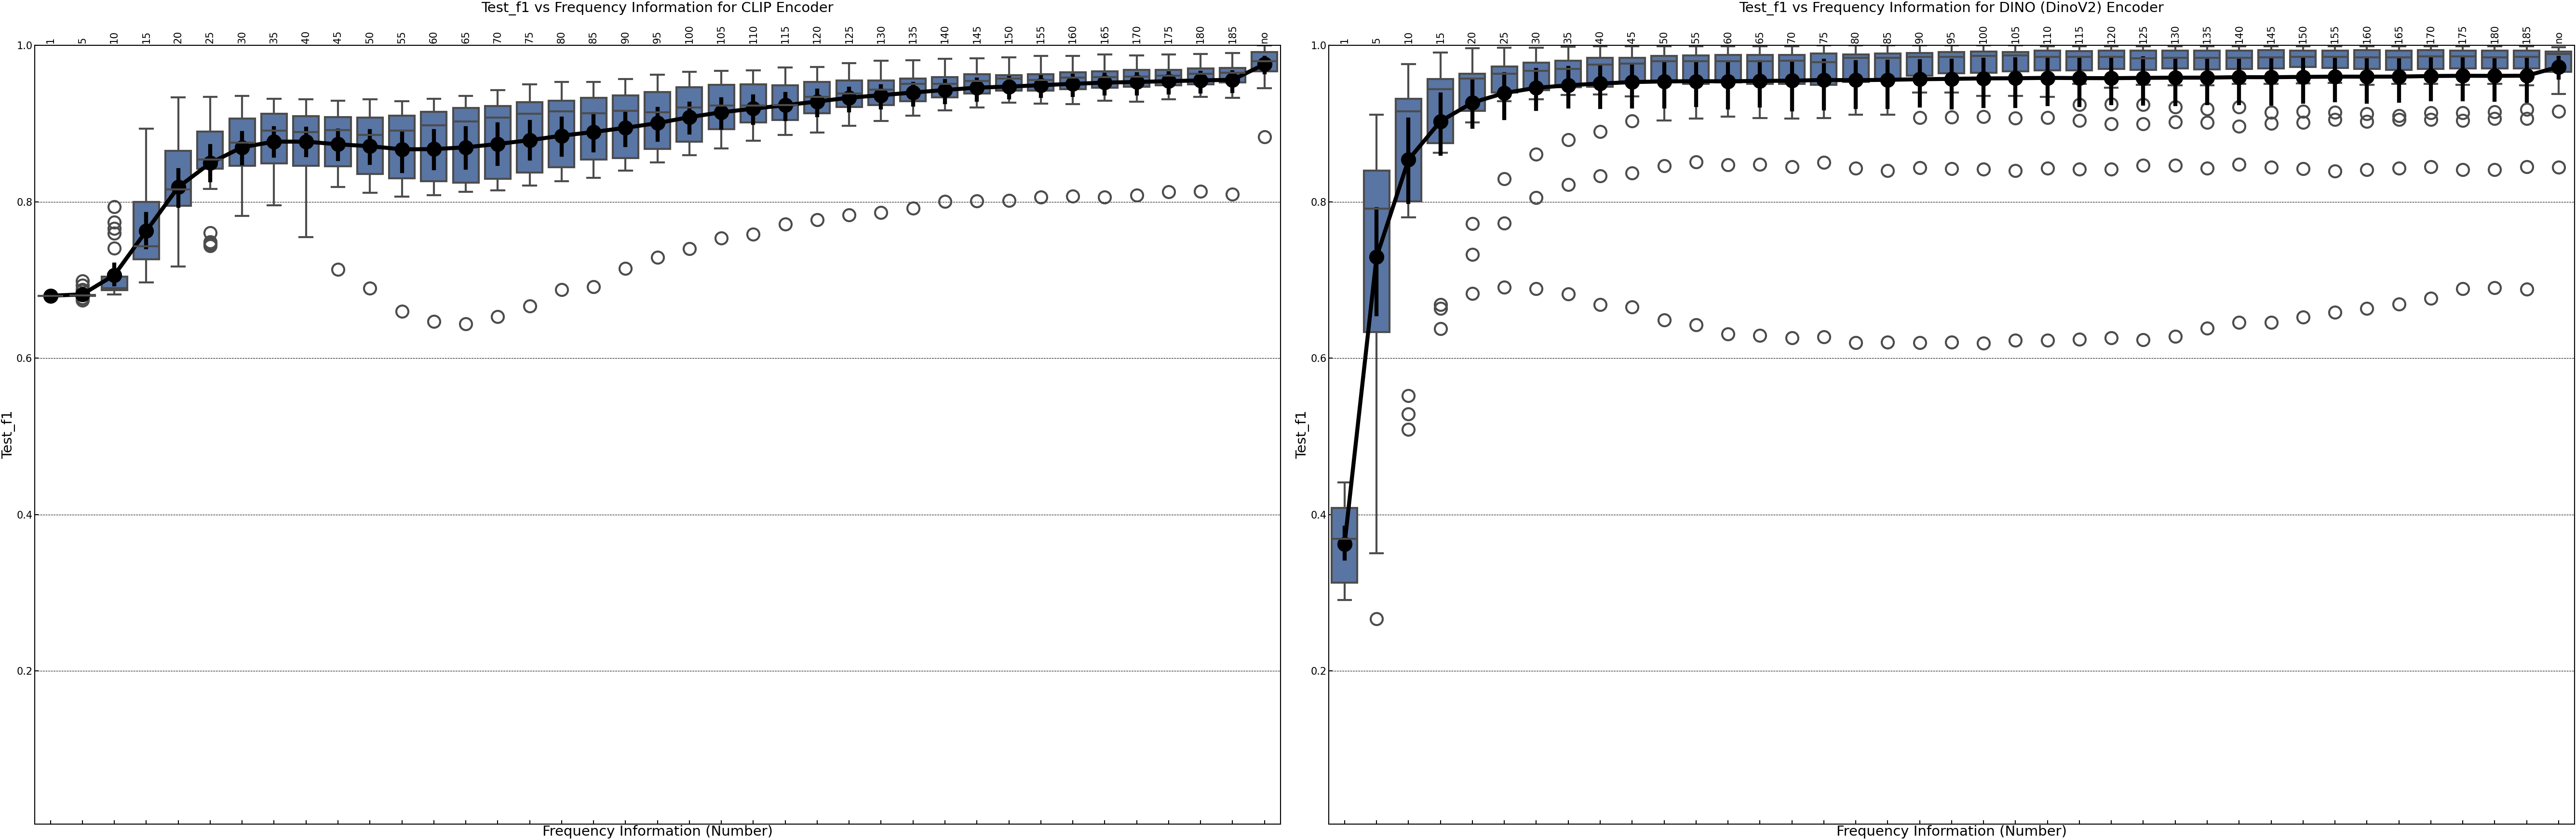

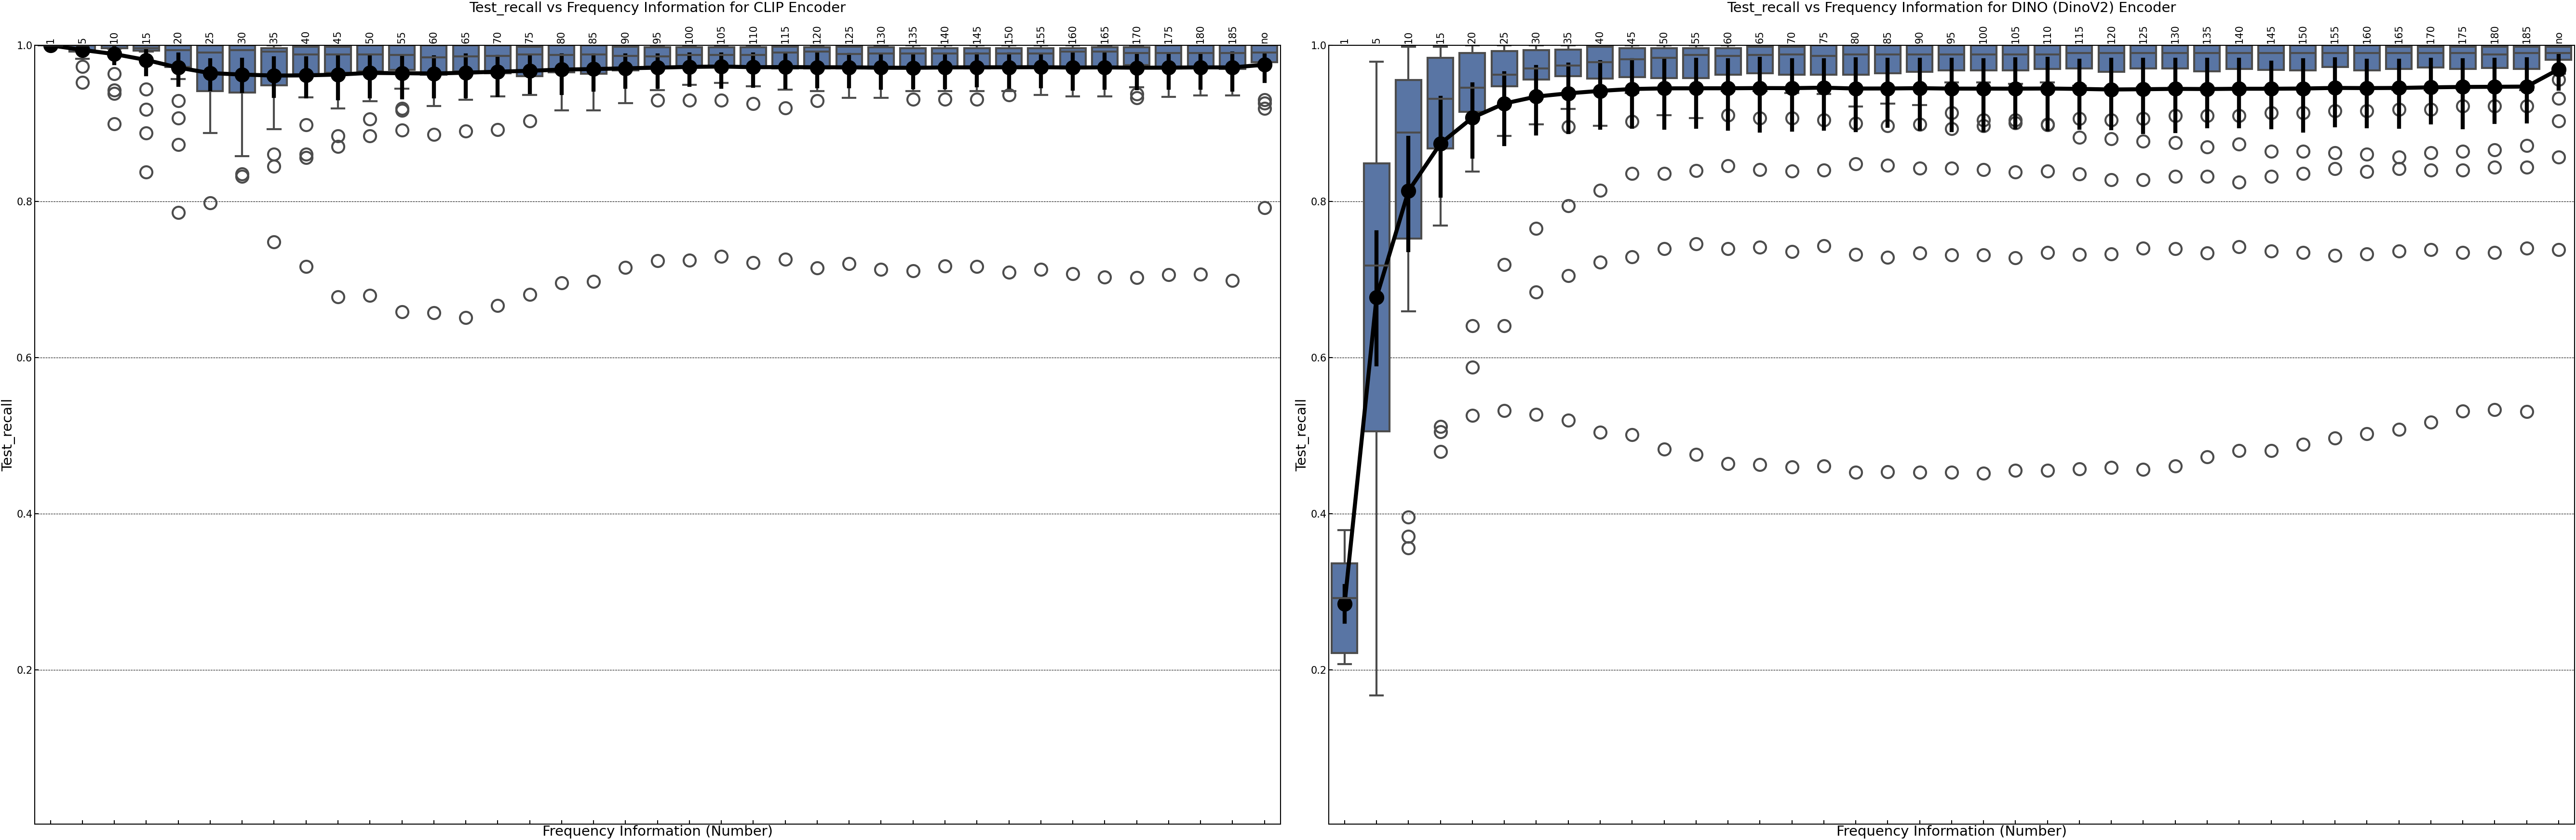

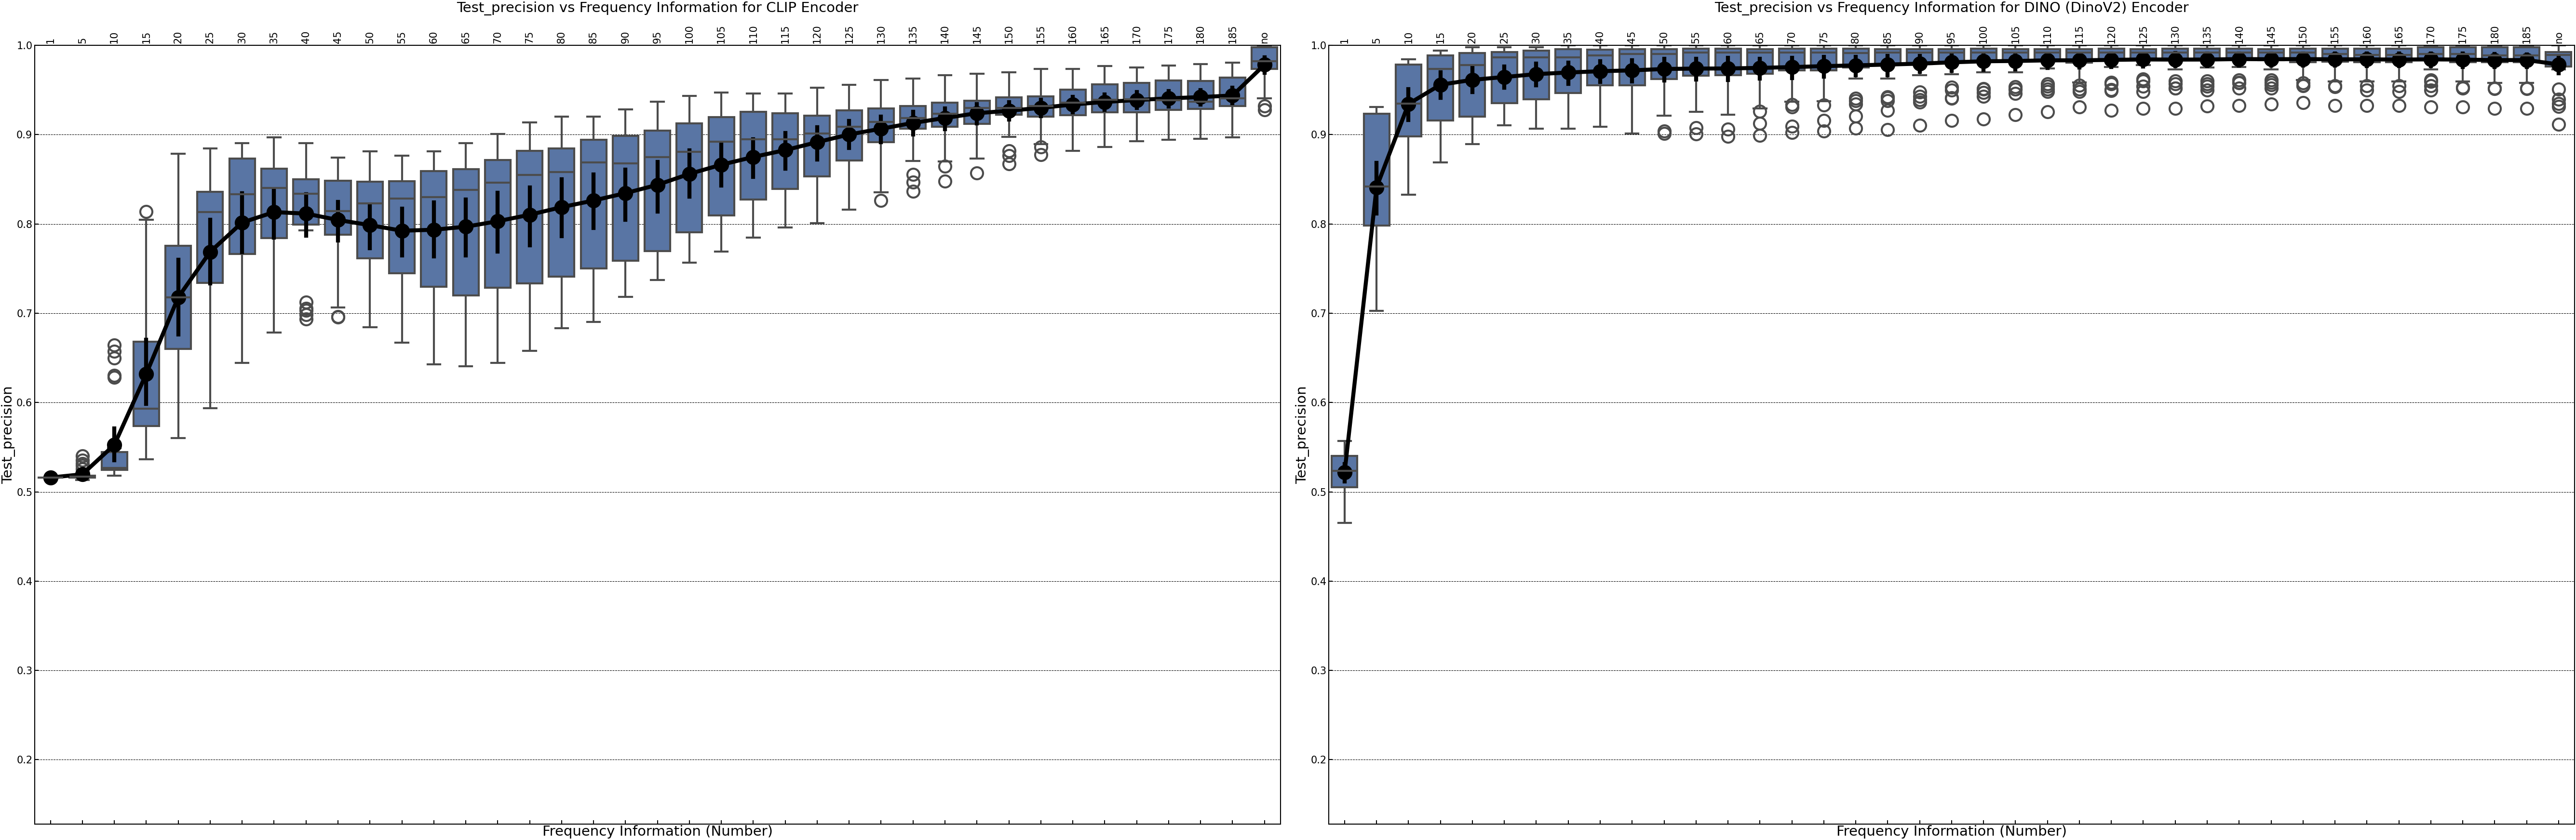

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


filtered_data = df[(df['Experiment'] != 'coco') & (df['Generator'] != 'coco')]#& (df['Generator'] != 'ADM')
filtered_data = filtered_data[filtered_data['Generator'] != filtered_data['Experiment']]
dino_data_corrected = filtered_data[filtered_data['Encoder'] == 'DinoV2']
clip_data = filtered_data[filtered_data['Encoder'] == 'OpenClip']
metrics = ['test_f1', 'test_recall', 'test_precision']
sns.set_palette('deep')


dino_data_corrected = dino_data_corrected[(dino_data_corrected["Generator"].isin(Gans))&(dino_data_corrected["Experiment"].isin(Diffs))]
clip_data = clip_data[(clip_data["Generator"].isin(Gans))&(clip_data["Experiment"].isin(Diffs))]
# Creating a figure for each metric
for metric in metrics:
    global_min_y = filtered_data[metric].min()
    global_max_y = filtered_data[metric].max()
    plt.figure(figsize=(18, 6))

    # Boxplot for CLIP encoder
    plt.subplot(1, 2, 1)
    
    sns.boxplot(x='Number', y=metric, data=clip_data)
    sns.pointplot(x='Number', y=metric, data=clip_data, color='black', markersize=6, linewidth=2)
    plt.xticks(rotation=90)
    plt.ylim(global_min_y, global_max_y) 
    plt.title(f'{metric.capitalize().replace("test_", "")} vs Frequency Information for CLIP Encoder')
    plt.xlabel('Frequency Information (Number)')
    plt.ylabel(metric.capitalize().replace("test_", ""))

    # Boxplot for DINO (DinoV2) encoder
    plt.subplot(1, 2, 2)
    if not dino_data_corrected.empty:
        sns.boxplot(x='Number', y=metric, data=dino_data_corrected)
        sns.pointplot(x='Number', y=metric, data=dino_data_corrected, color='black', markersize=6, linewidth=2)
        plt.xticks(rotation=90)
        plt.ylim(global_min_y, global_max_y) 
        plt.title(f'{metric.capitalize().replace("test_", "")} vs Frequency Information for DINO (DinoV2) Encoder')
        plt.xlabel('Frequency Information (Number)')
        plt.ylabel(metric.capitalize().replace("test_", ""))
    else:
        plt.text(0.5, 0.5, 'No data available for DINO (DinoV2) Encoder', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=plt.gca().transAxes)
        plt.title('Data Unavailable for DINO (DinoV2)')

    plt.tight_layout()
    plt.show()

Following the opservation, that the models trained on the gan images perform worse on the DM generated images, we want to see if this is due to a bias twoards a certain frequency spectrum. 

### The Impact of Frequency Removal on the Classification Performace. 

To Understand if or even which frequency bands are most important for the classification of a given generator, we low pass filter the image using a butterworth filter. Butterworth has the advandge of generating less "rippels" aka artifcats in the inverse fourier. So we increase with a step size of 5 the filter, and see how that impacts the classification performance. It is important that we take the False Postive and False Negative Rate into perspective, as a High flase postive would indicate a a fake image dump, while a false negative rate, would indicate a basis towards classifiying images as real. 


As a first step, we want to compare the two models for all experiments and generators. We do this, to see if there are any specific patterns that are destinc towards the encoder. As coco was trained on a completely different dataset, we exclude it for the analysis, as it would not be a fair comparison. We also remove the performance on the own data.
Then we also plot the recall, to see if the model starts to overclassify images a real, even though they are fake. Meaning, it starts to dump images into the real category.

Then we also plot the precision, to see if the model starts to overclassify images a fake, even though they are real. Meaning, it starts to dump images into the fake category.


As we have seen earlier that the there is a clear difference between models trained on gans and models trained on diff models. We want to see if we can determine which could be the reason for it. 


    Encoder Experiment Generator Number  test_acc  test_recall  \
0  OpenClip      IDDPM  StyleGAN      1     0.516     1.000000   
1  OpenClip      IDDPM  StyleGAN      5     0.518     1.000000   
2  OpenClip      IDDPM  StyleGAN     10     0.569     1.000000   
3  OpenClip      IDDPM  StyleGAN     15     0.738     0.995723   
4  OpenClip      IDDPM  StyleGAN     20     0.841     0.972304   

   test_precision  test_roc_auc  test_pd_10  test_pd_05  test_pd_01   test_f1  \
0        0.516000      0.591272    0.086798    0.086798    0.011294  0.679876   
1        0.517008      0.510376    0.048137    0.000000    0.000000  0.680770   
2        0.544436      0.821339    0.451462    0.262854    0.094986  0.704464   
3        0.664466      0.924888    0.706736    0.546638    0.295351  0.796297   
4        0.774995      0.951792    0.809458    0.724559    0.385186  0.862168   

   tendency_to_overclassify_positive  tendency_to_overclassify_negative  
0                           0.484000      

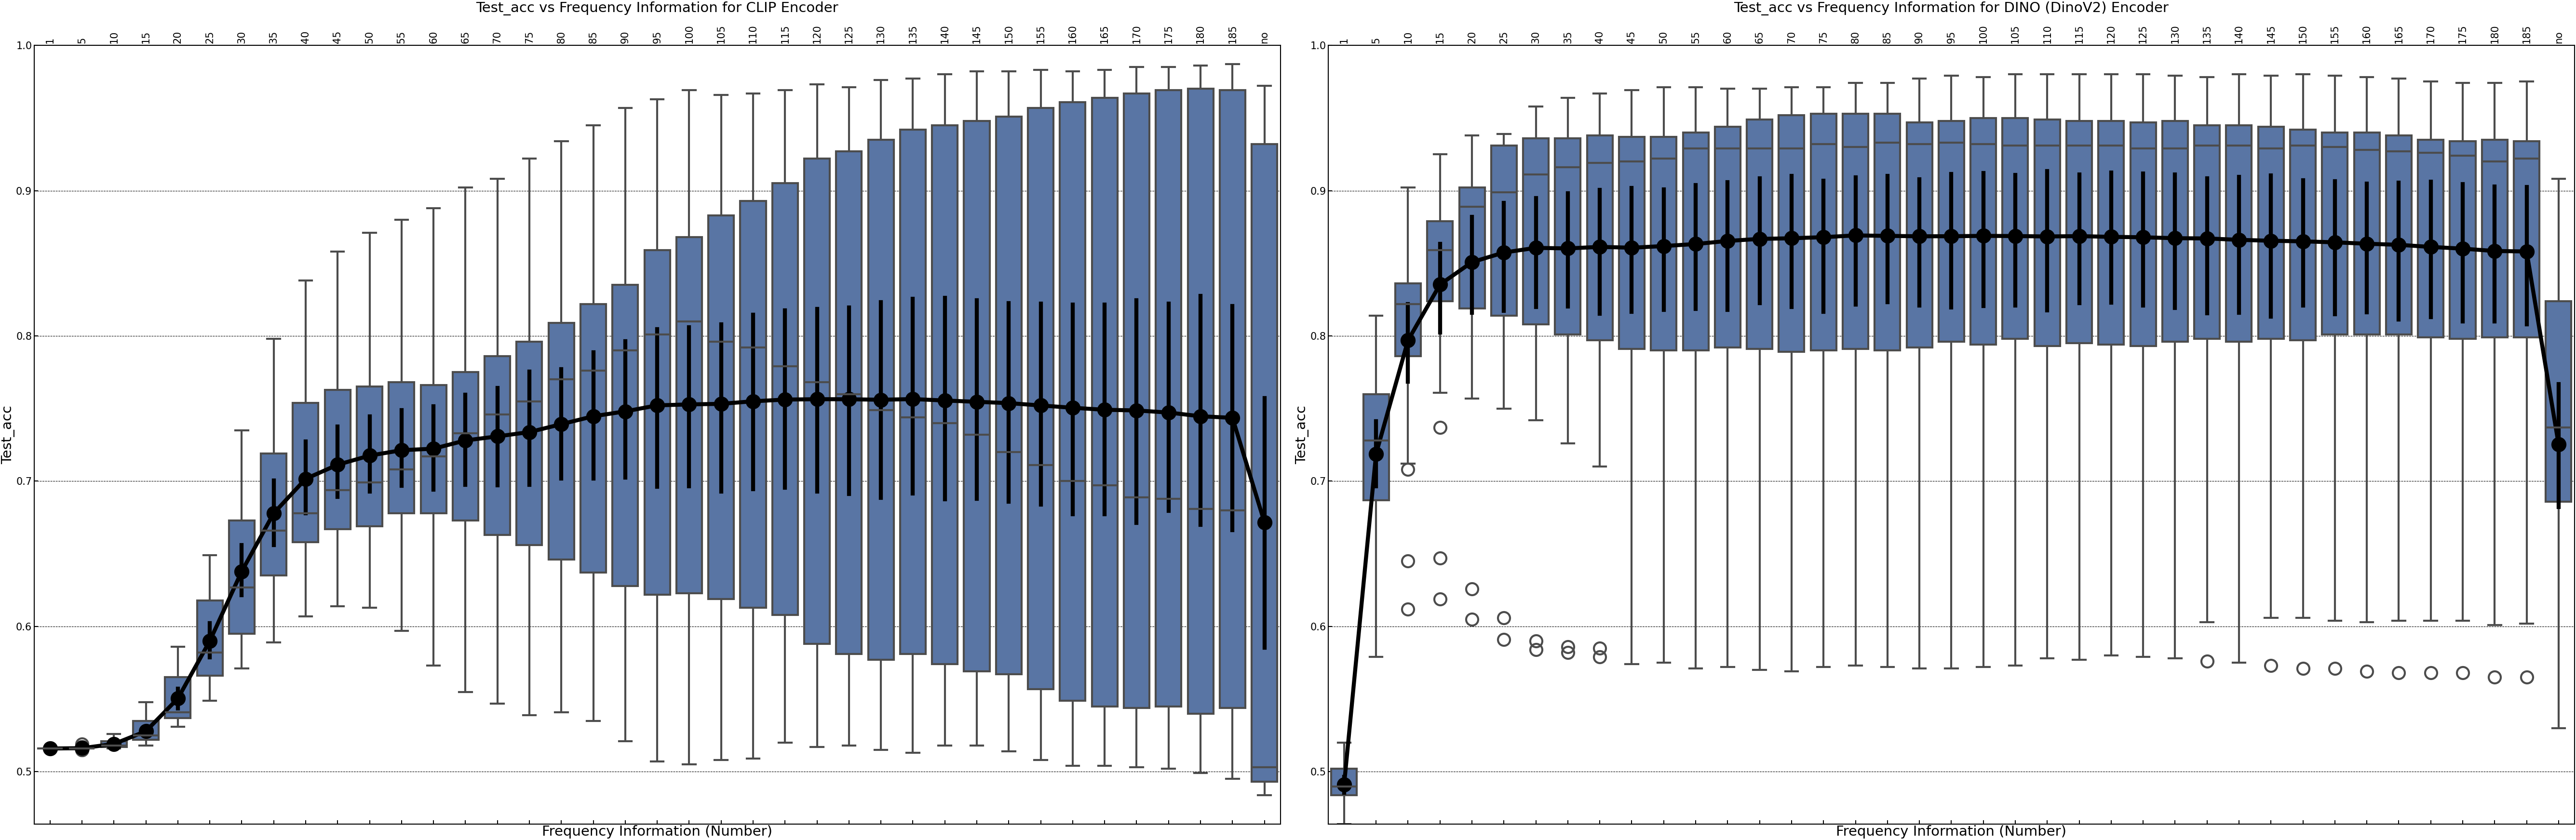

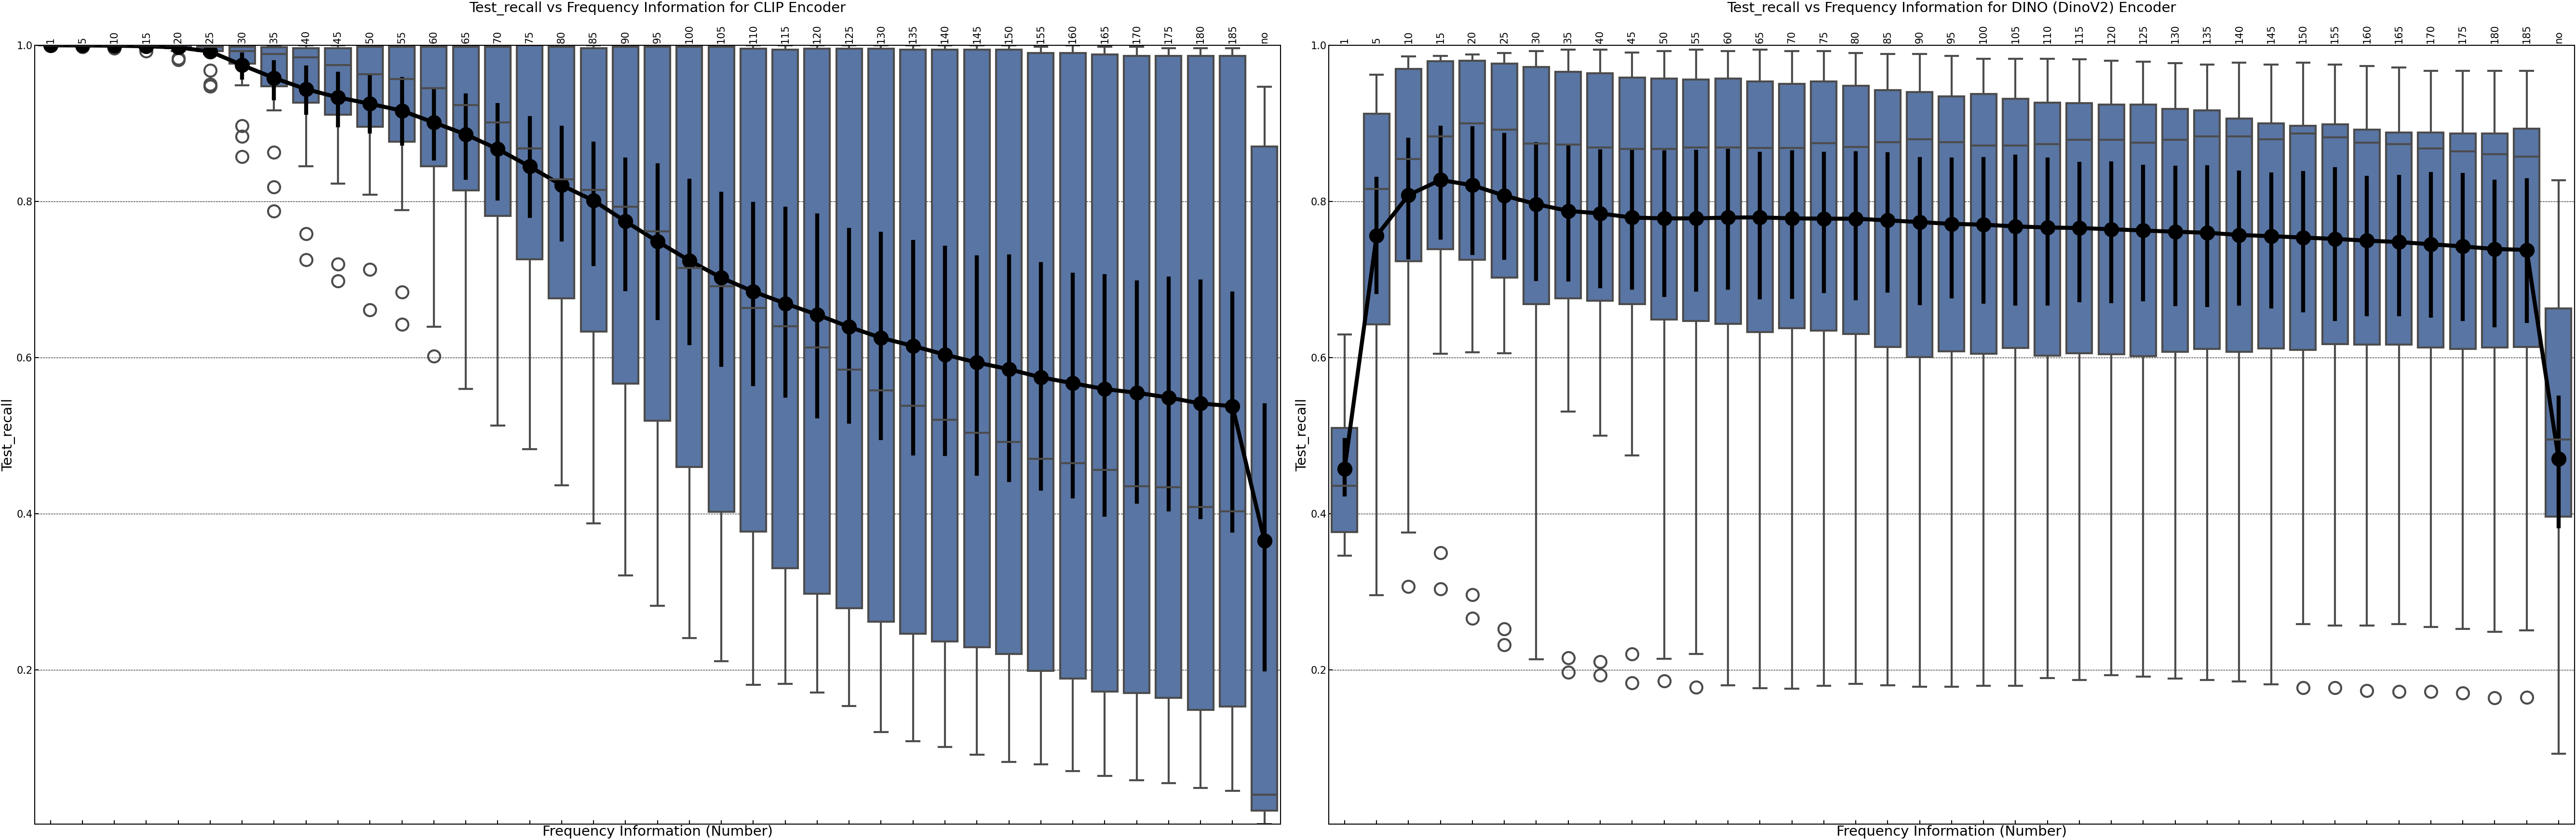

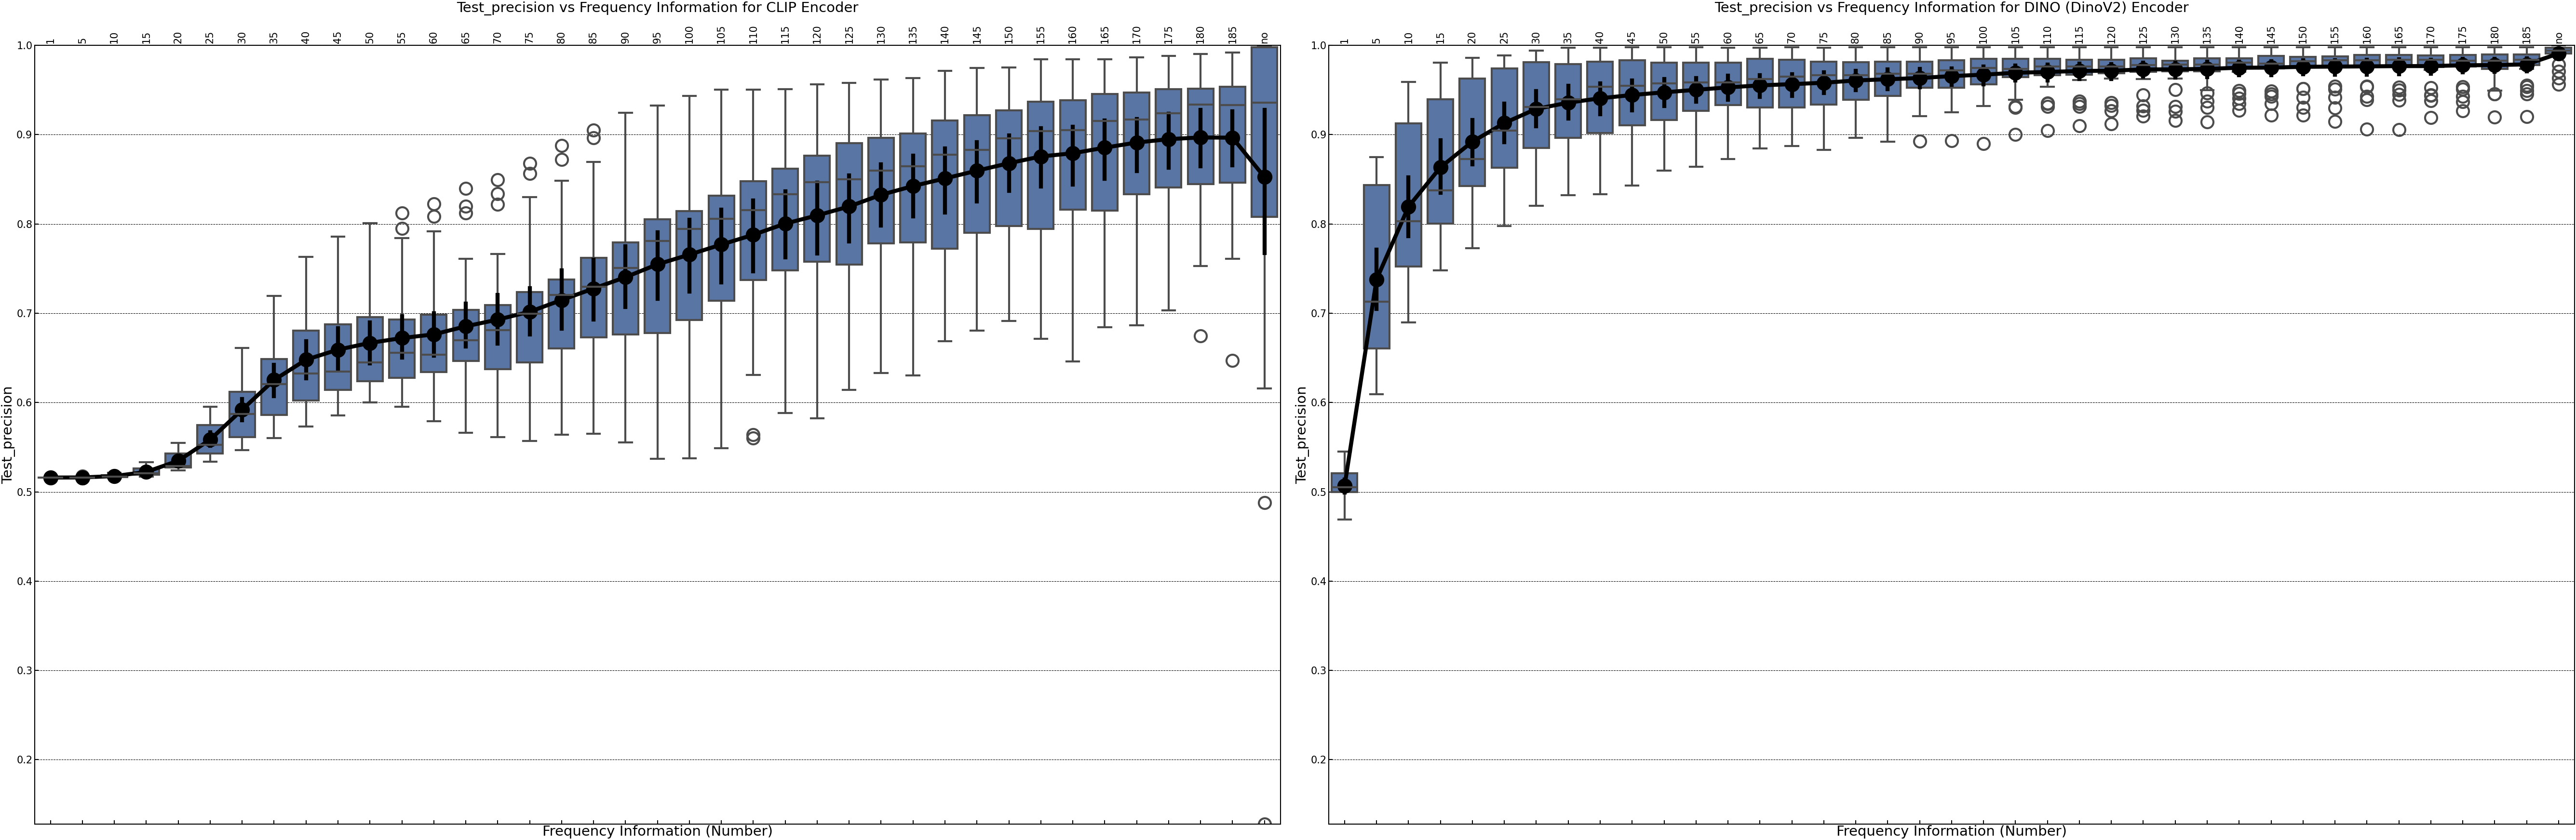

In [8]:
filtered_data = df[(df['Experiment'] != 'coco') & (df['Generator'] != 'coco')]#
filtered_data = filtered_data[filtered_data['Generator'] != filtered_data['Experiment']]
dino_data_corrected = filtered_data[filtered_data['Encoder'] == 'DinoV2']
clip_data = filtered_data[filtered_data['Encoder'] == 'OpenClip']
metrics = ['test_acc', 'test_recall', 'test_precision']
sns.set_palette('deep')
print(filtered_data.head())

dino_data_corrected = dino_data_corrected[(dino_data_corrected["Generator"].isin(Diffs))&(dino_data_corrected["Experiment"].isin(Gans))]
clip_data = clip_data[(clip_data["Generator"].isin(Diffs))&(clip_data["Experiment"].isin(Gans))]
# Creating a figure for each metric
for metric in metrics:
    global_min_y = filtered_data[metric].min()
    global_max_y = filtered_data[metric].max()
    plt.figure(figsize=(18, 6))

    # Boxplot for CLIP encoder
    plt.subplot(1, 2, 1)
    
    sns.boxplot(x='Number', y=metric, data=clip_data)
    sns.pointplot(x='Number', y=metric, data=clip_data, color='black', markersize=6, linewidth=2)
    plt.xticks(rotation=90)
    plt.ylim(global_min_y, global_max_y) 
    plt.title(f'{metric.capitalize().replace("test_", "")} vs Frequency Information for CLIP Encoder')
    plt.xlabel('Frequency Information (Number)')
    plt.ylabel(metric.capitalize().replace("test_", ""))

    # Boxplot for DINO (DinoV2) encoder
    plt.subplot(1, 2, 2)
    if not dino_data_corrected.empty:
        sns.boxplot(x='Number', y=metric, data=dino_data_corrected)
        sns.pointplot(x='Number', y=metric, data=dino_data_corrected, color='black', markersize=6, linewidth=2)
        plt.xticks(rotation=90)
        plt.ylim(global_min_y, global_max_y) 
        plt.title(f'{metric.capitalize().replace("test_", "")} vs Frequency Information for DINO (DinoV2) Encoder')
        plt.xlabel('Frequency Information (Number)')
        plt.ylabel(metric.capitalize().replace("test_", ""))
    else:
        plt.text(0.5, 0.5, 'No data available for DINO (DinoV2) Encoder', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=plt.gca().transAxes)
        plt.title('Data Unavailable for DINO (DinoV2)')

    plt.tight_layout()
    plt.show()

We can see here that clip tends to classify all images as fake, if there is no high frequency informaiton. When we give it more frequency information, the rate of missing fake images increases. Dino on the other hand, increases its recall the more information is provided. THis indicated that dino when trained on gan images checks also the low frequency domain, and makes it majority decission based on the highest frequencys. Both models, learned that when focusing on the highest frequenices, they best classify gans generated images, while for dino the lower frequencies also play a role. So if we train the model with the fourier filter, it should be able to better classify new unseen generators, as they can learn to learn to also focus on new bands. 
When looking a the precission, we see that dino realtivly fasts reduces the false postive rate, meaning to overclassifiying fake images. With dino, the rate slowly increases. So Dino is less likly tricked into thinking a image is fake, with lower frequencies. 

The data suggest that dino is able to utilize the lower frequency bands aswell for its classification. 



An idead would be to find the frequency where all models on average perform best for either gan or diff. 


Gans produce more noise in the higher frequencies then diffusion models. So when trained on gans, the models have problems handling diffusion models, where the noise in the higher frequencies is less distinct. This  has been shown by (paper). So if a model is able to utilize also lower frequencies in a efficient way, it performs should be good till the noisy higher frequecies are introduced. So we see that dino encodes lower frequencies better then clip. Meaning when training clip, the higher frequencies played a more important role in the classificaiton context. Yet in the self supervised training of dino, the lower frequencies play are more crucial role. So while both models utilize the full frequency range, dino handles the lower frequencies better. This is important, is the lower frequecies are less prone to noise, and thus more robust to unseen generators. 

To now fully utilize the lower frequencies, we want to train the model with a low pass filter. Here it is important to note, that all images need to be lowpass filtered. This is possible as we do not finetune the weights of the encoder it self, which still is able to produce the embeddings of unfilter images correctly, we just ensure that the classification layer is able to focus the lower frequencies. So if the training is succesfull, dino should be able to classify unseen generators better, as it is able to utilize the lower frequencies. If this holds up, the training paradigm for dino does improve foundation models in the sense, that more low frequency information is encoded. This information is important for a variety of tasks, such as ... .

When looking into the training paradigm used for dino and clip, it is mentioned in the dino paper they use a gausian blur effect, which is a low pass filter. While in the clip paper they do not use it. This could be the reason why dino is better in focusing on lower frequencies, and in our case it brings a wide range of advantages. So we have a task, which can not soley be solved with higher frequencie information, we should train the model with a low pass filter. This not only reduces the noise in the higher frequencies, but also forces the model to focus on the lower frequencies, which contain valuble information for certain tasks.

We hypothesis that dino can better encode lowfrequency information dues to the augmentaitons used during training. In Training they always apply the Gausian Blur on all student data, which forces the model to encode the basic understanding of the image based on those frequencies. As we could see in the privous section, Dino is able to utilize the lower frequencies better then clip. This is important, as the lower frequencies are less prone to noise (paper that shows this). Even more so, it was shown that diffusion models also show artificats in the mid-to high frequenzy range. What is interesting though, is that dino can sperate between gans and dinos in the mid frequency range way better then in the high frequency range.


Lowpass filtering does imporve performance. This is contradicting the conjecture claimned int (paper), which states the the lowpass filtering makes them indistinguishable. 

It is also shown that higher frequencies in diffusion models show simalr artifcats as naturall images in the with jpeg compresseion.(Frourier Diff paper). The same paper delivers the conjecture, that infact mid frequecny deliver 



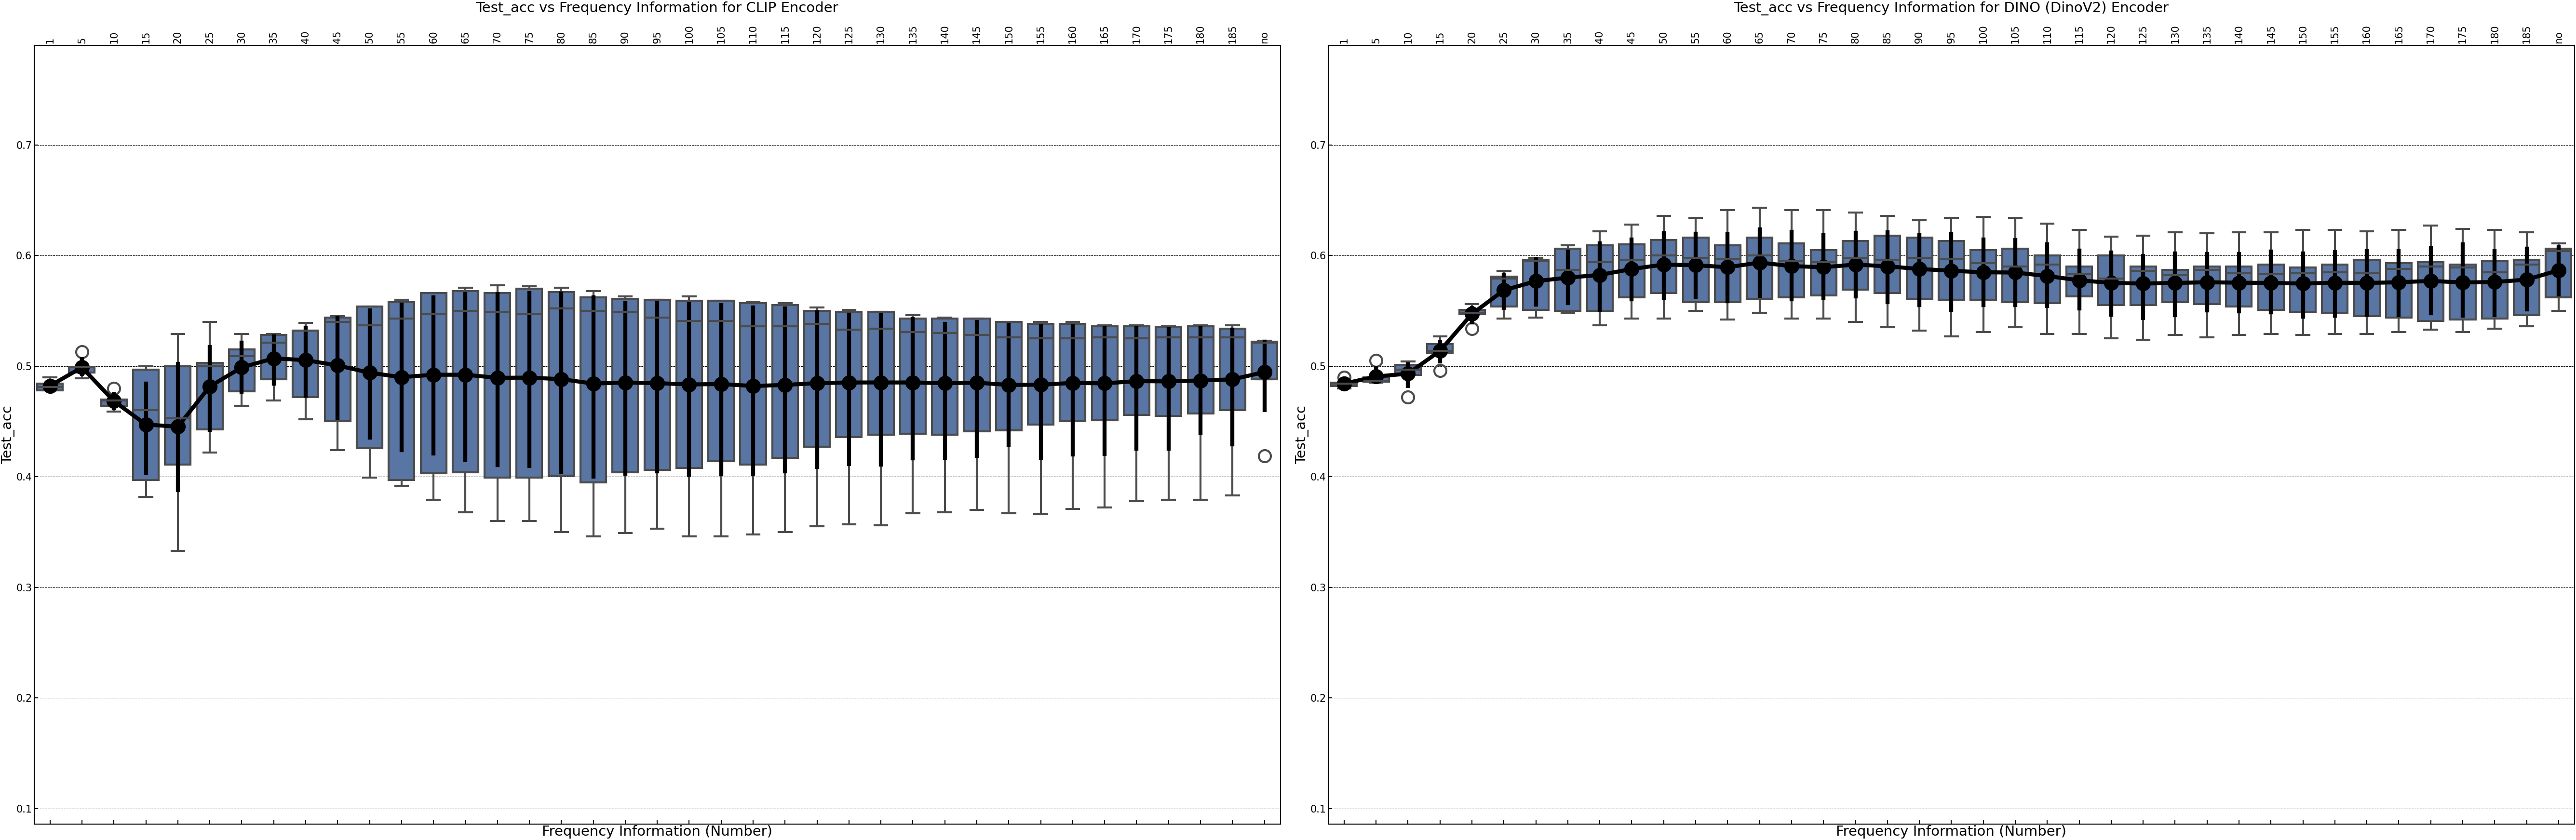

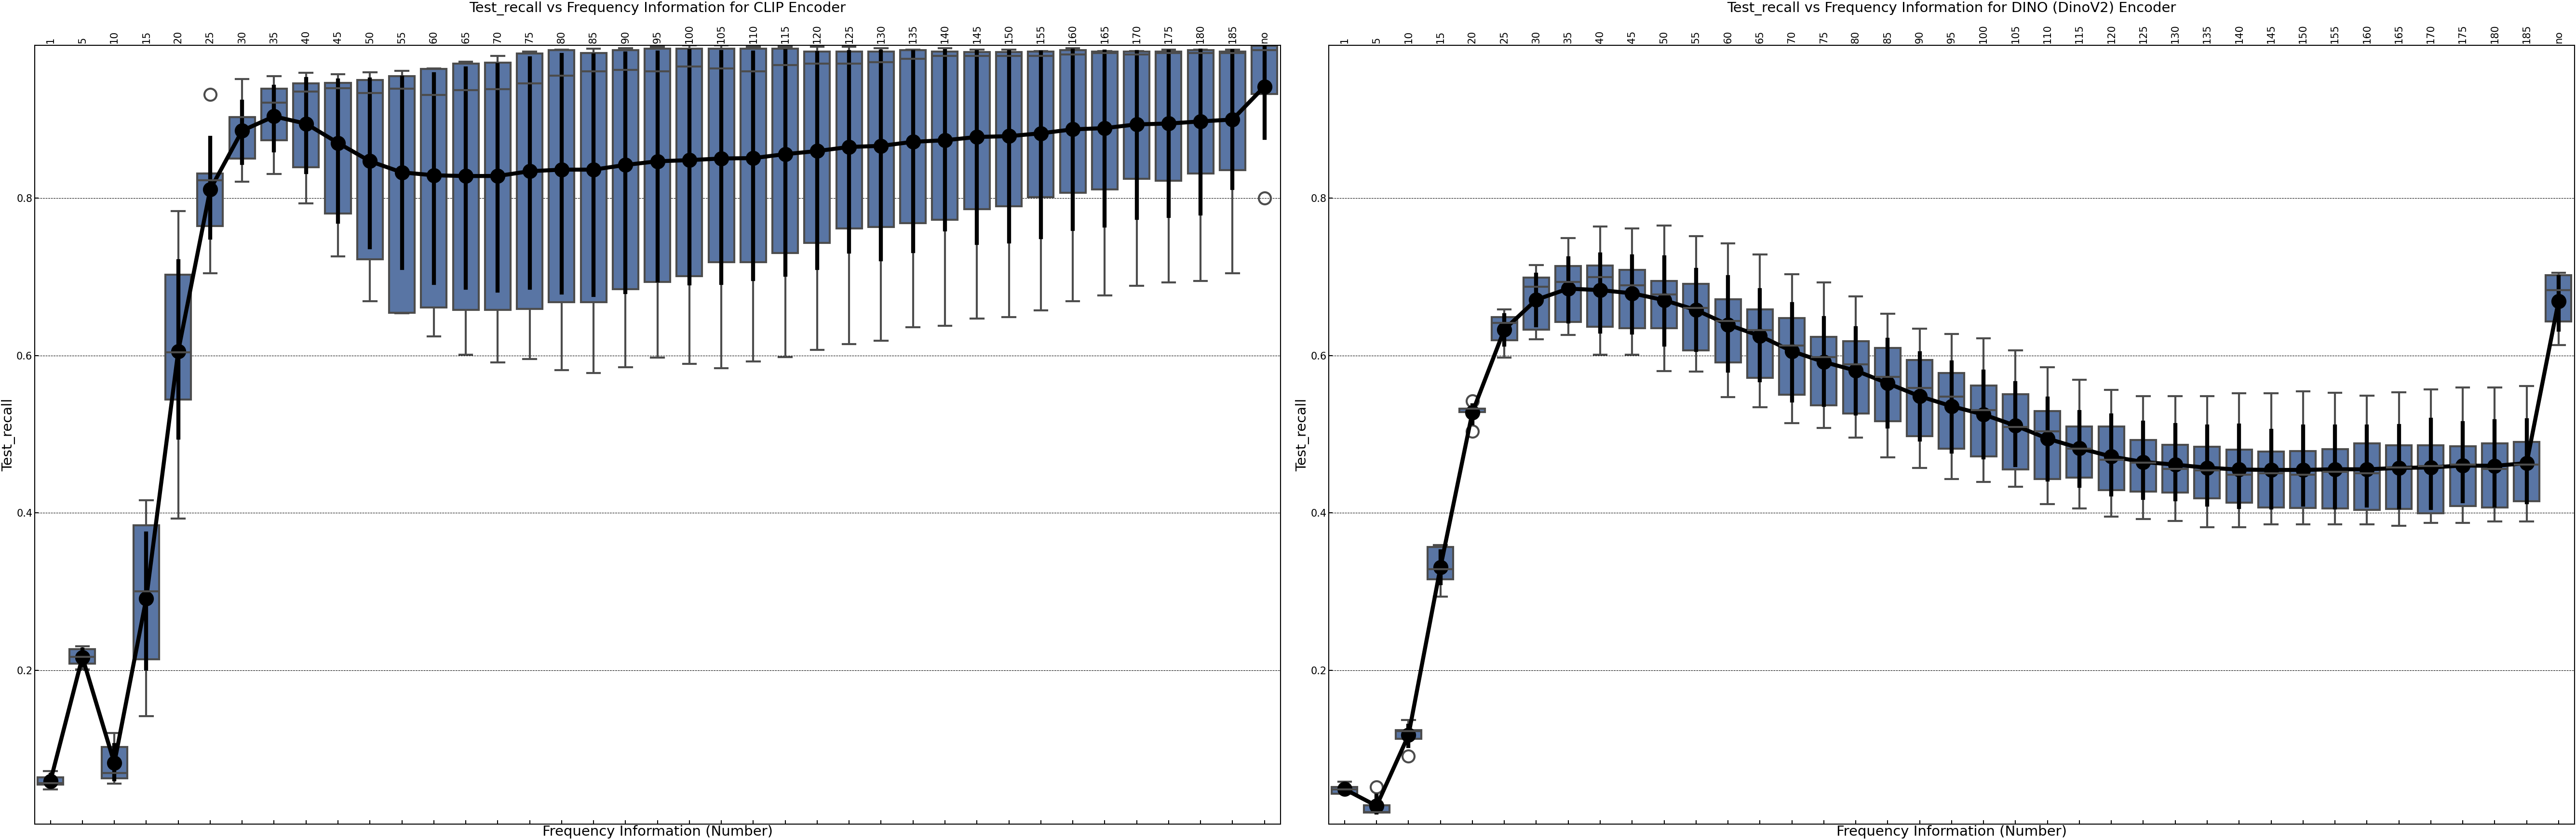

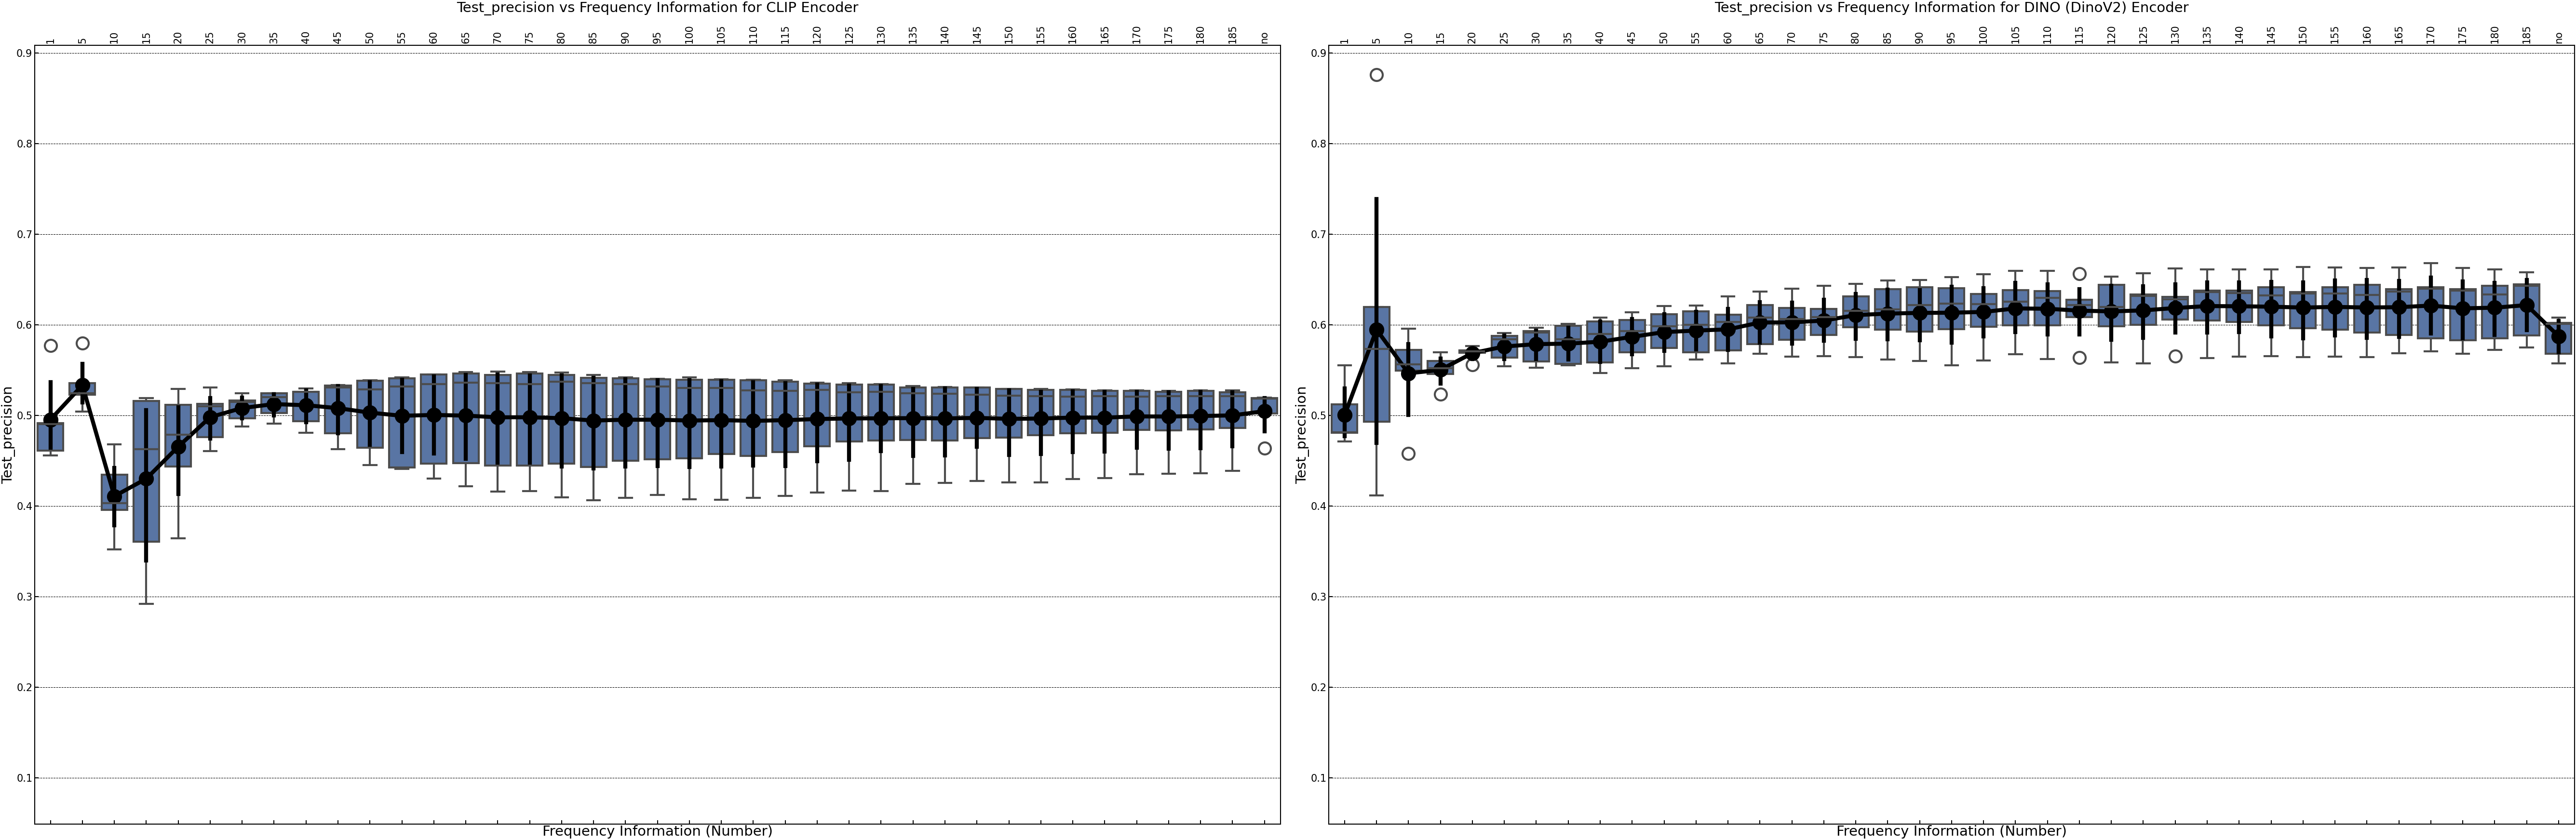

In [9]:
filtered_data = df[(df['Experiment'] == 'coco') & (df['Generator'] != 'coco')]
#filtered_data = filtered_data[filtered_data['Generator'] != filtered_data['Experiment']]
dino_data_corrected = filtered_data[filtered_data['Encoder'] == 'DinoV2']
clip_data = filtered_data[filtered_data['Encoder'] == 'OpenClip']
metrics = ['test_acc', 'test_recall', 'test_precision']
sns.set_palette('deep')


dino_data_corrected = dino_data_corrected[(dino_data_corrected["Generator"].isin(Diffs))]
clip_data = clip_data[(clip_data["Generator"].isin(Diffs))]
# Creating a figure for each metric
for metric in metrics:
    global_min_y = filtered_data[metric].min()
    global_max_y = filtered_data[metric].max()
    plt.figure(figsize=(18, 6))

    # Boxplot for CLIP encoder
    plt.subplot(1, 2, 1)
    
    sns.boxplot(x='Number', y=metric, data=clip_data)
    sns.pointplot(x='Number', y=metric, data=clip_data, color='black', markersize=6, linewidth=2)
    plt.xticks(rotation=90)
    plt.ylim(global_min_y, global_max_y) 
    plt.title(f'{metric.capitalize().replace("test_", "")} vs Frequency Information for CLIP Encoder')
    plt.xlabel('Frequency Information (Number)')
    plt.ylabel(metric.capitalize().replace("test_", ""))

    # Boxplot for DINO (DinoV2) encoder
    plt.subplot(1, 2, 2)
    if not dino_data_corrected.empty:
        sns.boxplot(x='Number', y=metric, data=dino_data_corrected)
        sns.pointplot(x='Number', y=metric, data=dino_data_corrected, color='black', markersize=6, linewidth=2)
        plt.xticks(rotation=90)
        plt.ylim(global_min_y, global_max_y) 
        plt.title(f'{metric.capitalize().replace("test_", "")} vs Frequency Information for DINO (DinoV2) Encoder')
        plt.xlabel('Frequency Information (Number)')
        plt.ylabel(metric.capitalize().replace("test_", ""))
    else:
        plt.text(0.5, 0.5, 'No data available for DINO (DinoV2) Encoder', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=plt.gca().transAxes)
        plt.title('Data Unavailable for DINO (DinoV2)')

    plt.tight_layout()
    plt.show()

Now we check, if face with the same datatype, if model has different behaviour. We



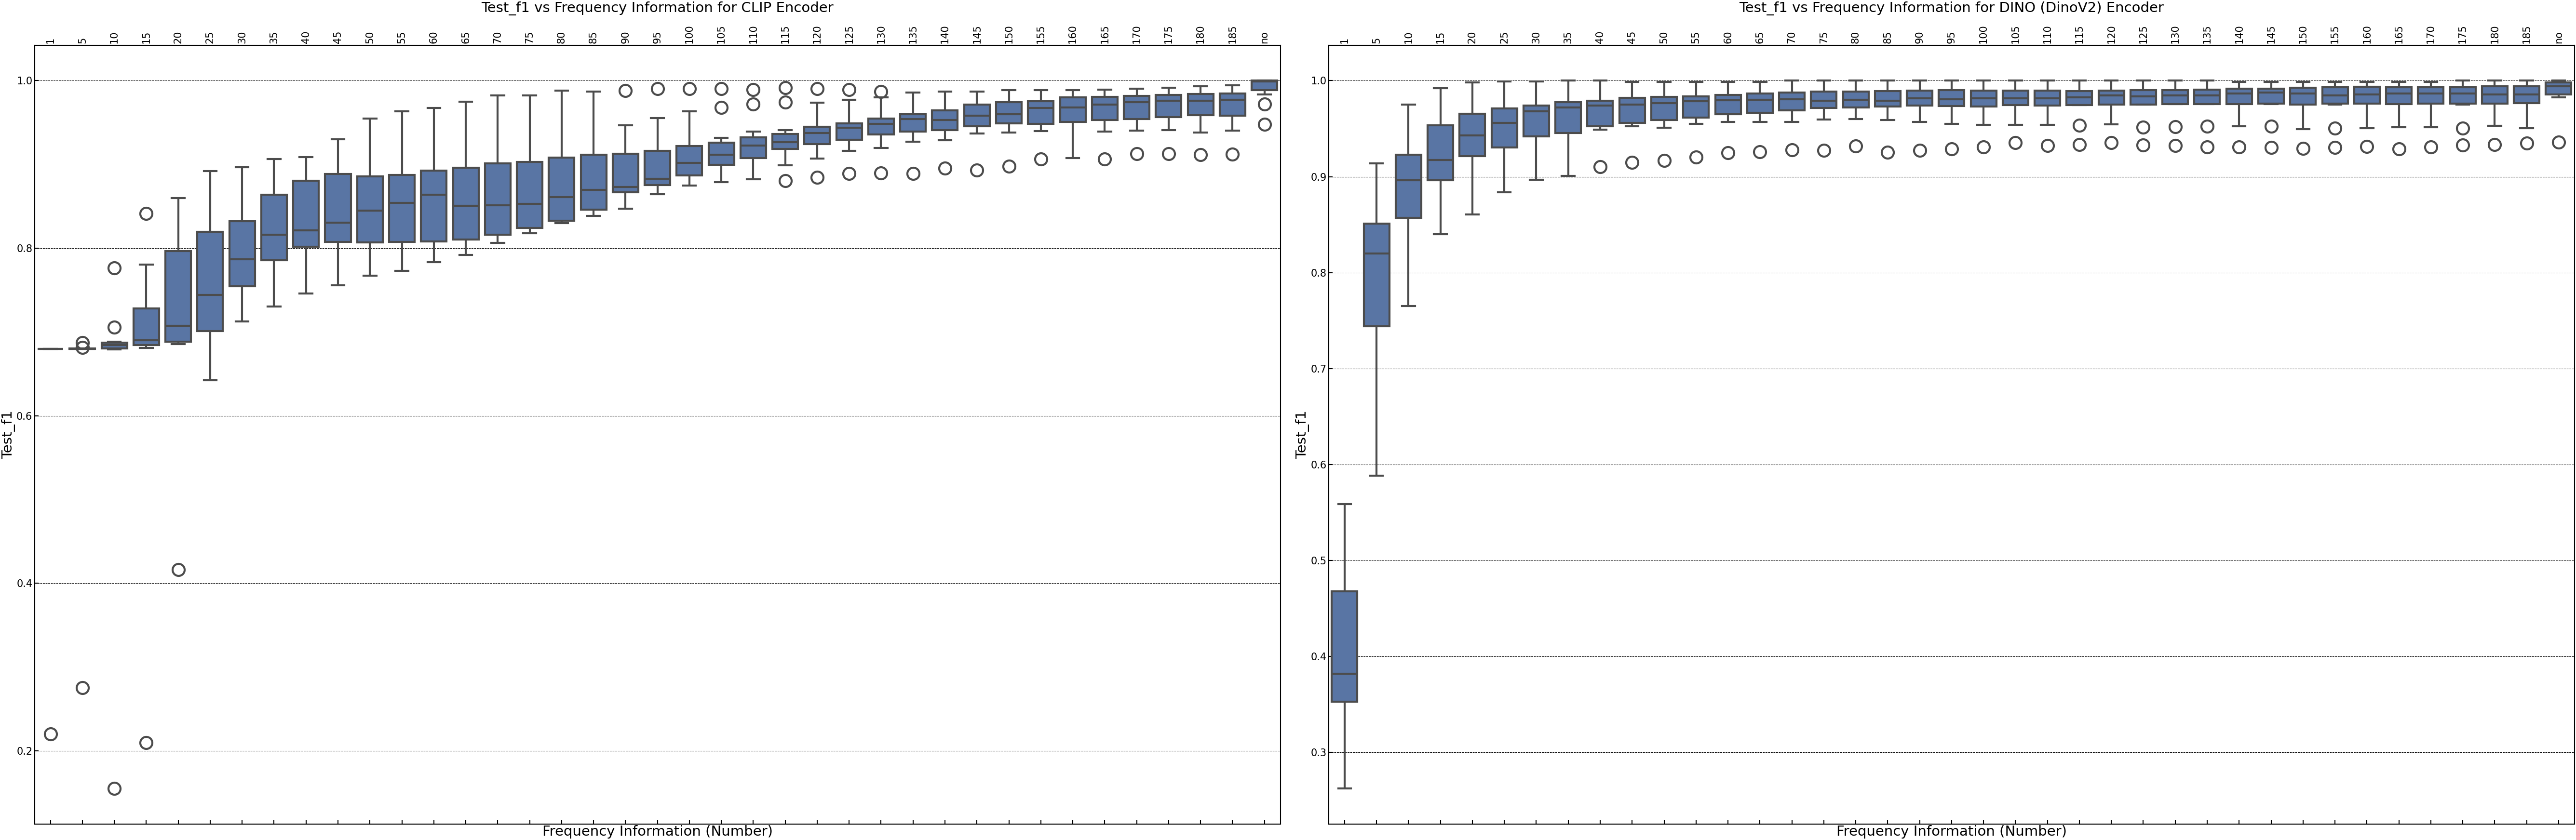

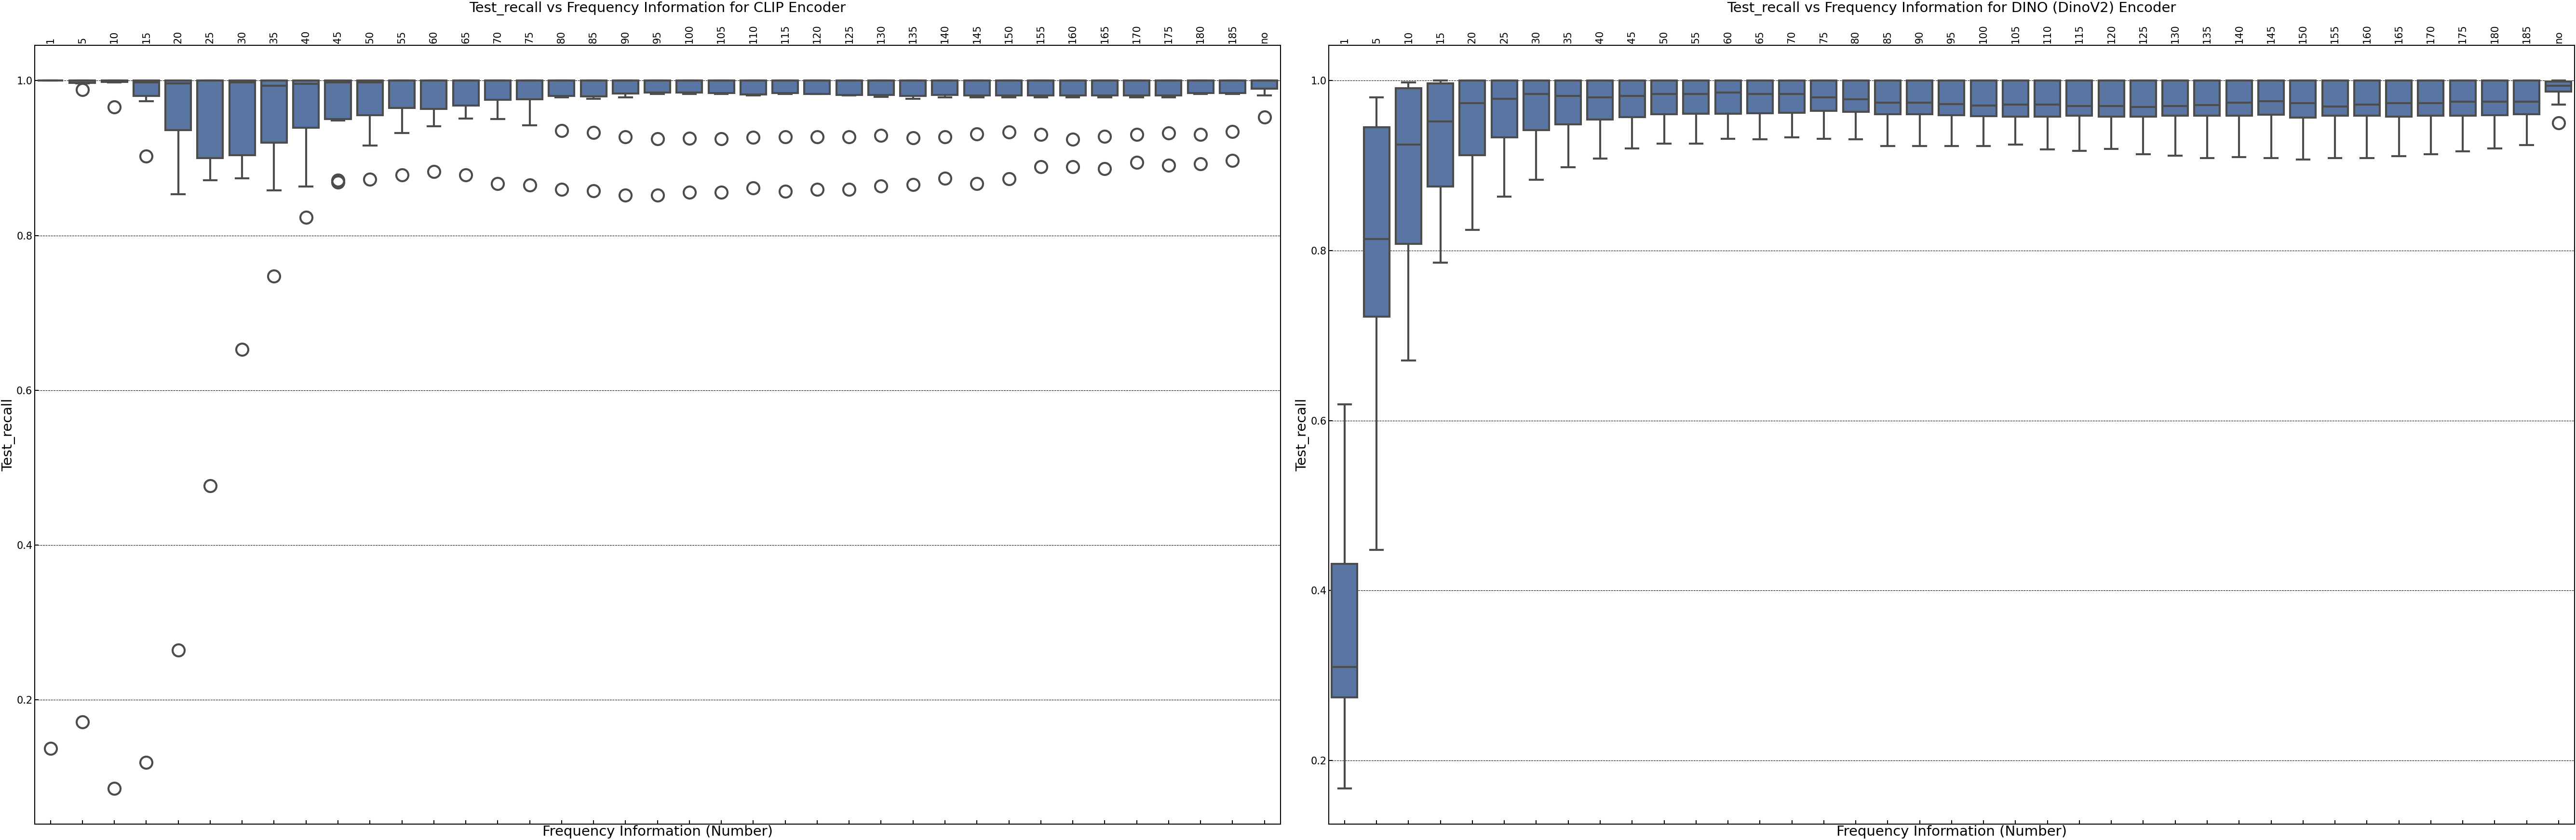

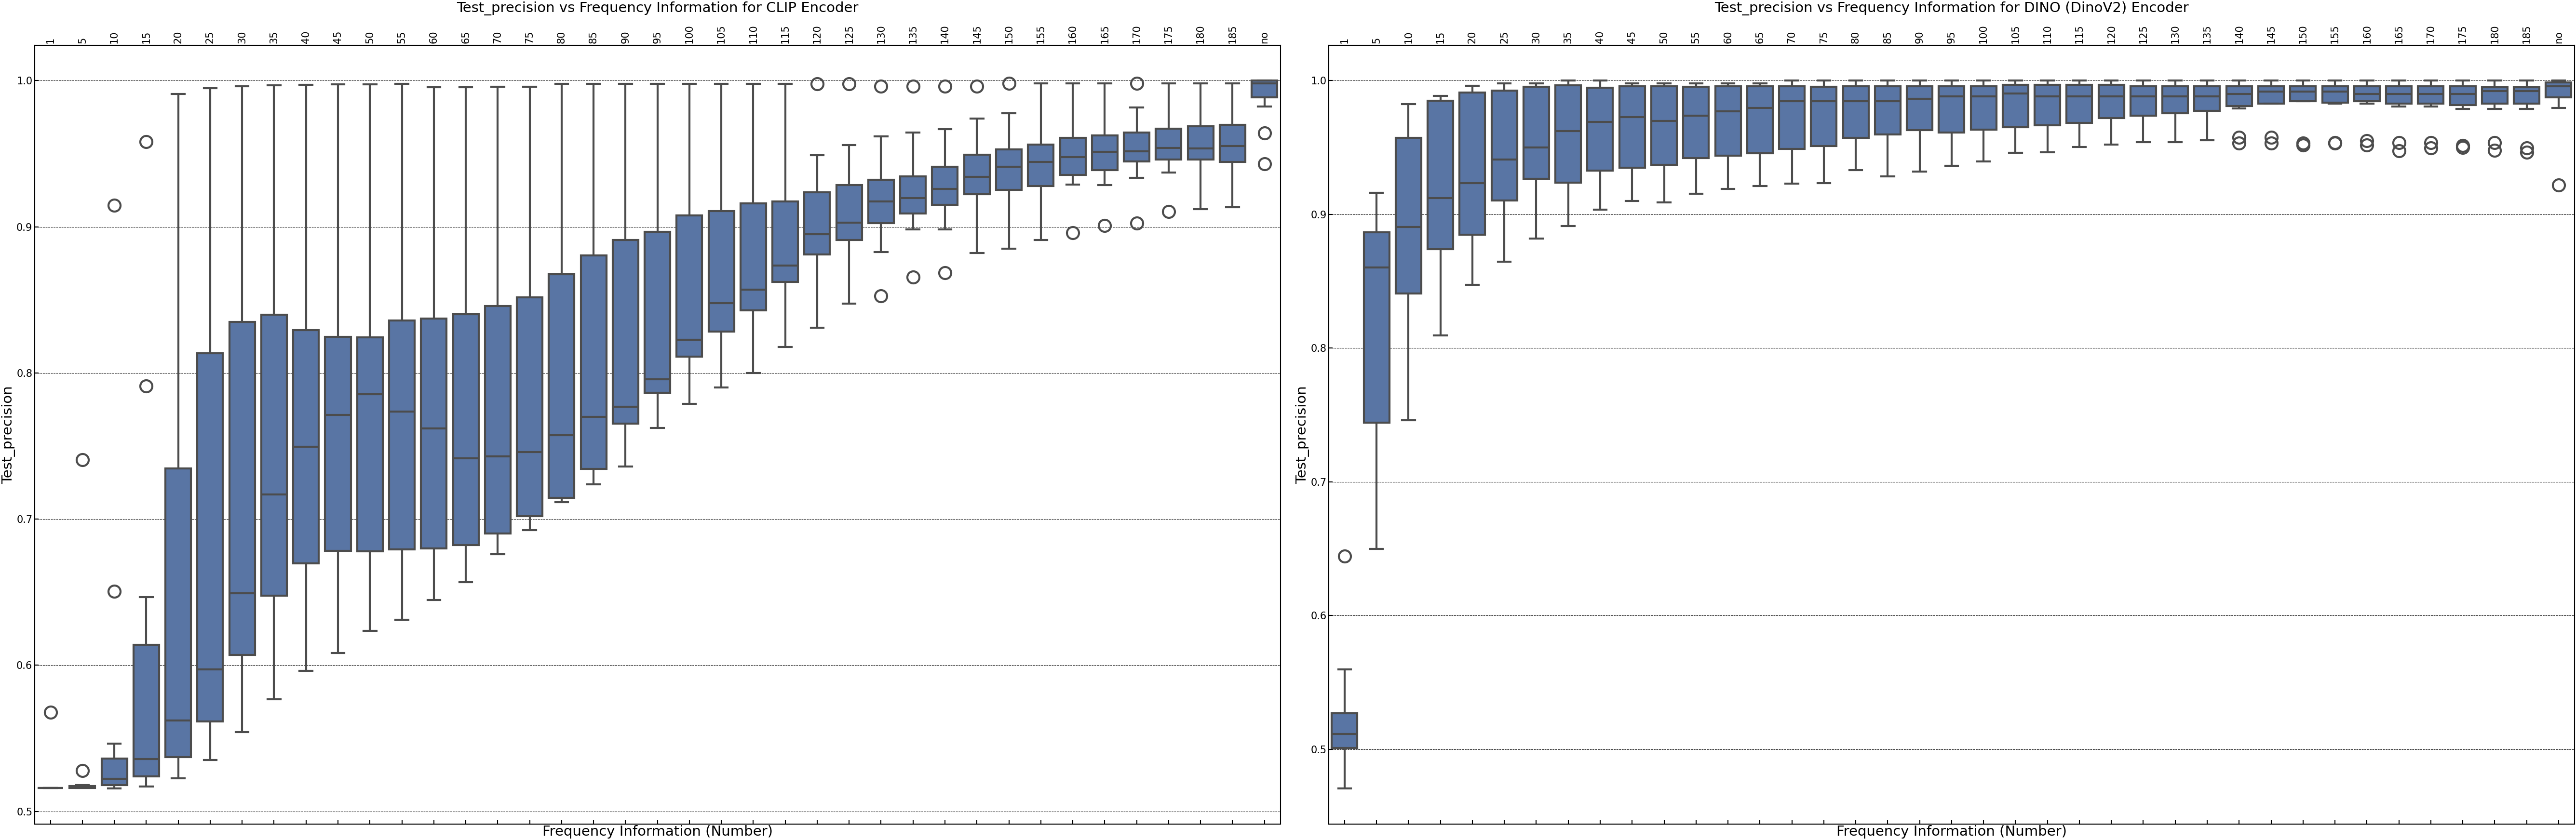

In [10]:
filtered_data = df[df['Generator'] == df['Experiment']]
dino_data_corrected = filtered_data[filtered_data['Encoder'] == 'DinoV2']
clip_data = filtered_data[filtered_data['Encoder'] == 'OpenClip']
metrics = ['test_f1', 'test_recall', 'test_precision']
sns.set_palette('deep')
# Creating a figure for each metric
for metric in metrics:
    plt.figure(figsize=(18, 6))

    # Boxplot for CLIP encoder
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Number', y=metric, data=clip_data)
    plt.xticks(rotation=90)
    plt.title(f'{metric.capitalize().replace("test_", "")} vs Frequency Information for CLIP Encoder')
    plt.xlabel('Frequency Information (Number)')
    plt.ylabel(metric.capitalize().replace("test_", ""))

    # Boxplot for DINO (DinoV2) encoder
    plt.subplot(1, 2, 2)
    if not dino_data_corrected.empty:
        sns.boxplot(x='Number', y=metric, data=dino_data_corrected)
        plt.xticks(rotation=90)
        plt.title(f'{metric.capitalize().replace("test_", "")} vs Frequency Information for DINO (DinoV2) Encoder')
        plt.xlabel('Frequency Information (Number)')
        plt.ylabel(metric.capitalize().replace("test_", ""))
    else:
        plt.text(0.5, 0.5, f'No data available for DINO (DinoV2) Encoder', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=plt.gca().transAxes)
        plt.title('Data Unavailable for DINO (DinoV2)')

    plt.tight_layout()
    plt.show()

If there is an easy distinction for example in the high frequency specturm for a model, that model should generally be better performing when when a input data also has that aspect. 

Here we compare how the different experiments behave. To Ensure no domain shift problems within the lsun trained generators. 

We also seperate between Gans and diffusion trained models. So that the generator will be diffs if trained on a gan and visa versa for diffs.

To better compare the plots, we have to 

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

data = df
data = data[data['Generator'] != "coco"]
data["Number"].replace("no", 200, inplace=True)
dino_data_corrected = data[data['Encoder'] == 'DinoV2']
clip_data = data[data['Encoder'] == 'OpenClip']
sns.set_palette('deep')
head_key = "Experiment"
y = "test_f1"
plt.figure(figsize=(18, len(data[head_key].unique()) * 6))

# Find global y-axis limits
global_min_y = data[y].min()
global_max_y = data[y].max()

for i, experiment in enumerate(data[head_key].unique()):
    dino_experiment_data = dino_data_corrected[dino_data_corrected[head_key] == experiment]
    clip_experiment_data = clip_data[clip_data[head_key] == experiment]

    # Similar filtering for Gans and Diffs...

    if experiment in Gans:
        dino_experiment_data = dino_experiment_data[dino_experiment_data["Generator"].isin(Diffs)]
        clip_experiment_data = clip_experiment_data[clip_experiment_data["Generator"].isin(Diffs)]
    elif experiment in Diffs:
        dino_experiment_data = dino_experiment_data[dino_experiment_data["Generator"].isin(Gans)]
        clip_experiment_data = clip_experiment_data[clip_experiment_data["Generator"].isin(Gans)]

    # Boxplot for CLIP encoder
    plt.subplot(len(data[head_key].unique()), 2, 2*i + 1)
    if not clip_experiment_data.empty:
        sns.boxplot(x='Number', y=y, data=clip_experiment_data, color='lightgray')
        sns.pointplot(x='Number', y=y, data=clip_experiment_data, color='black', scale=0.75)
        plt.xticks(rotation=90)
        plt.ylim(global_min_y, global_max_y)  # Set the global y-axis limits
        plt.title(f'F1 Score vs Frequency Information for CLIP Encoder - {experiment}')
        plt.xlabel('Frequency Information (Number)')
        plt.ylabel('F1 Score')
    else:
        plt.text(0.5, 0.5, f'No data available for CLIP Encoder - {experiment}', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=plt.gca().transAxes)
        plt.title(f'Data Unavailable for CLIP - {experiment}')

    # Boxplot for DINO (DinoV2) encoder
    plt.subplot(len(data[head_key].unique()), 2, 2*i + 2)
    if not dino_experiment_data.empty:
        sns.boxplot(x='Number', y=y, data=dino_experiment_data, color='lightgray')
        sns.pointplot(x='Number', y=y, data=dino_experiment_data, color='black', scale=0.75)
        plt.xticks(rotation=90)
        plt.ylim(global_min_y, global_max_y)  # Set the global y-axis limits
        plt.title(f'F1 Score vs Frequency Information for DINO (DinoV2) Encoder - {experiment}')
        plt.xlabel('Frequency Information (Number)')
        plt.ylabel('F1 Score')
    else:
        plt.text(0.5, 0.5, f'No data available for DINO (DinoV2) Encoder - {experiment}', 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=plt.gca().transAxes)
        plt.title(f'Data Unavailable for DINO (DinoV2) - {experiment}')

plt.tight_layout()
plt.show()


/tmp/ipykernel_71415/1668309787.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Number"].replace("no", 200, inplace=True)
/tmp/ipykernel_71415/1668309787.py:35: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='Number', y=y, data=clip_experiment_data, color='black', scale=0.75)


/tmp/ipykernel_71415/1668309787.py:51: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='Number', y=y, data=dino_experiment_data, color='black', scale=0.75)
/tmp/ipykernel_71415/1668309787.py:35: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='Number', y=y, data=clip_experiment_data, color='black', scale=0.75)
/tmp/ipykernel_71415/1668309787.py:51: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='Number', y=y, data=dino_experiment_data, color='black'

### Analyse the impact of FDA Swichting on the Classification performance

When low frequencies from a real image are injected into a target image, a low recall rate indicates that the model is mistaking fake images for real ones. Initially, this might seem disadvantageous, as it could potentially allow the model to be tricked into classifying an altered image as genuine. However, it could also demonstrate the encoder's proficiency in processing low-level features. Ideally, this capability should result in a real image being correctly identified as real, hence a higher precision score. If the model fails to do so, it effectively creates a repository for misidentified real images. Moreover, the model may inaccurately flag images with unusual frequency characteristics as fake, even when such peculiarities arise from authentic, unaltered sources.




